### Load Libraries

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq
from scipy import signal
from scipy.signal import savgol_filter
import math 
import img2pdf
import os
import glob

### Choose Static and Data

In [33]:
static_data = 'shf_1b'
burn = '5sec_Burn'

# Define steady state start and end times for averages 
# Initialize as NaN if no steady state is known yet (put "= float('nan')" )
'''

'''
# start_seconds = float('nan')
# end_seconds = float('nan')

start_seconds = 1
end_seconds = 5
# reference the following for preliminsary start/stop times
# https://docs.google.com/document/d/1UHtYmllSjSfc6lIi_eYmNaBHVCWk9syig7V9DK7WE98/edit?tab=t.0

start_steady_state_LC = start_seconds
end_steady_state_LC = end_seconds

start_steady_state_PT = start_seconds
end_steady_state_PT = end_seconds

start_steady_state_TC = float('nan')
end_steady_state_TC = float('nan')

## Load Data

In [ ]:
Data_Folder = f"./clean_data/{static_data}/{burn}/"
Sensor_Defiinitions_csv = f"./clean_data/{static_data}/SensorDefinitions_{static_data}.csv"

label_csv = pd.read_csv(Sensor_Defiinitions_csv)

def read_clean_data(pattern):
    files = glob.glob(f"{Data_Folder}/{pattern}*.csv") 
    if files:
        return pd.concat([pd.read_csv(file) for file in files], ignore_index=True)
    else:
        print(f"No files found for pattern {pattern}")
        return pd.DataFrame()  

# Read data for Clean_lc, Clean_pt, and Clean_tc
LC_df = read_clean_data("clean_LC")
PT_df = read_clean_data("clean_PT")
TC_df = read_clean_data("clean_TC")

## Pre Process Data 

# Plots of everything 

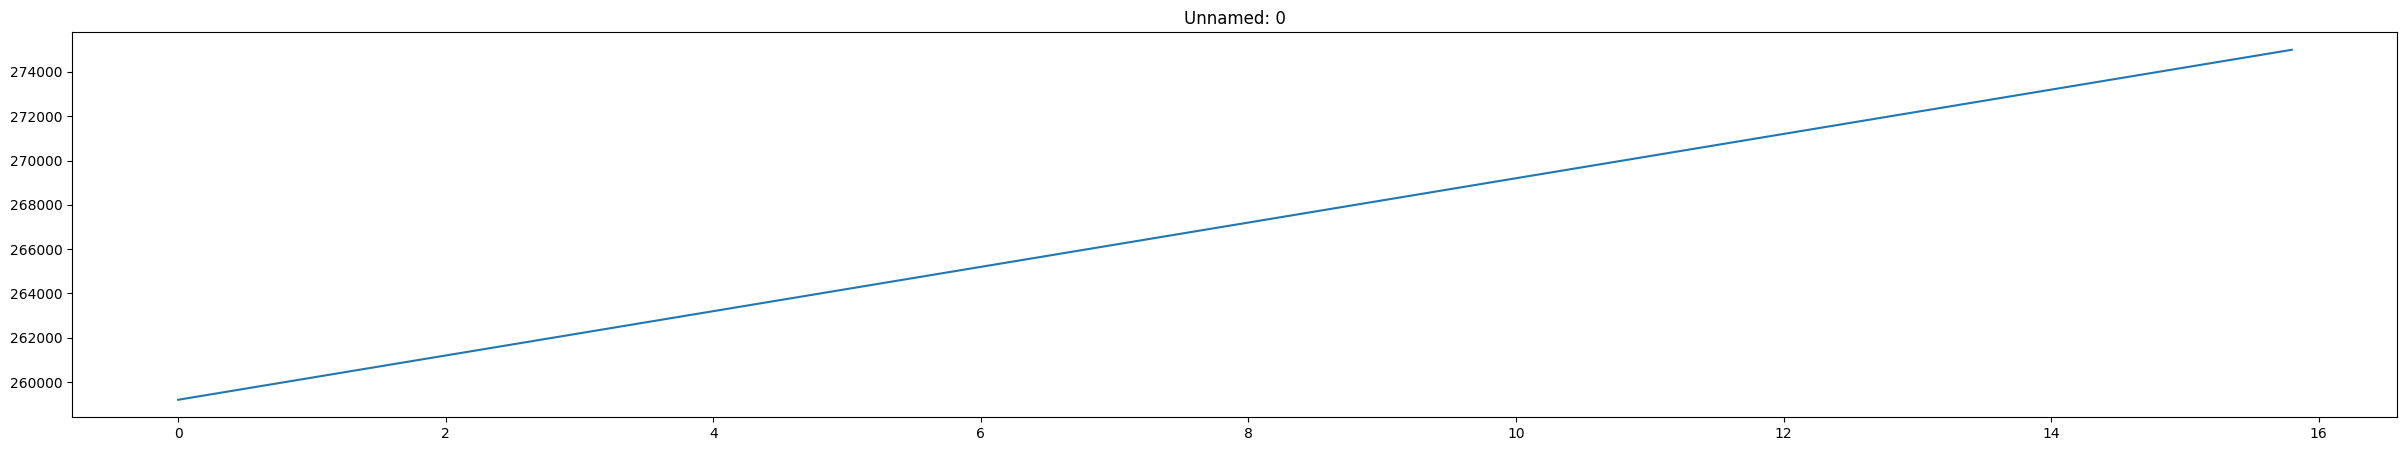

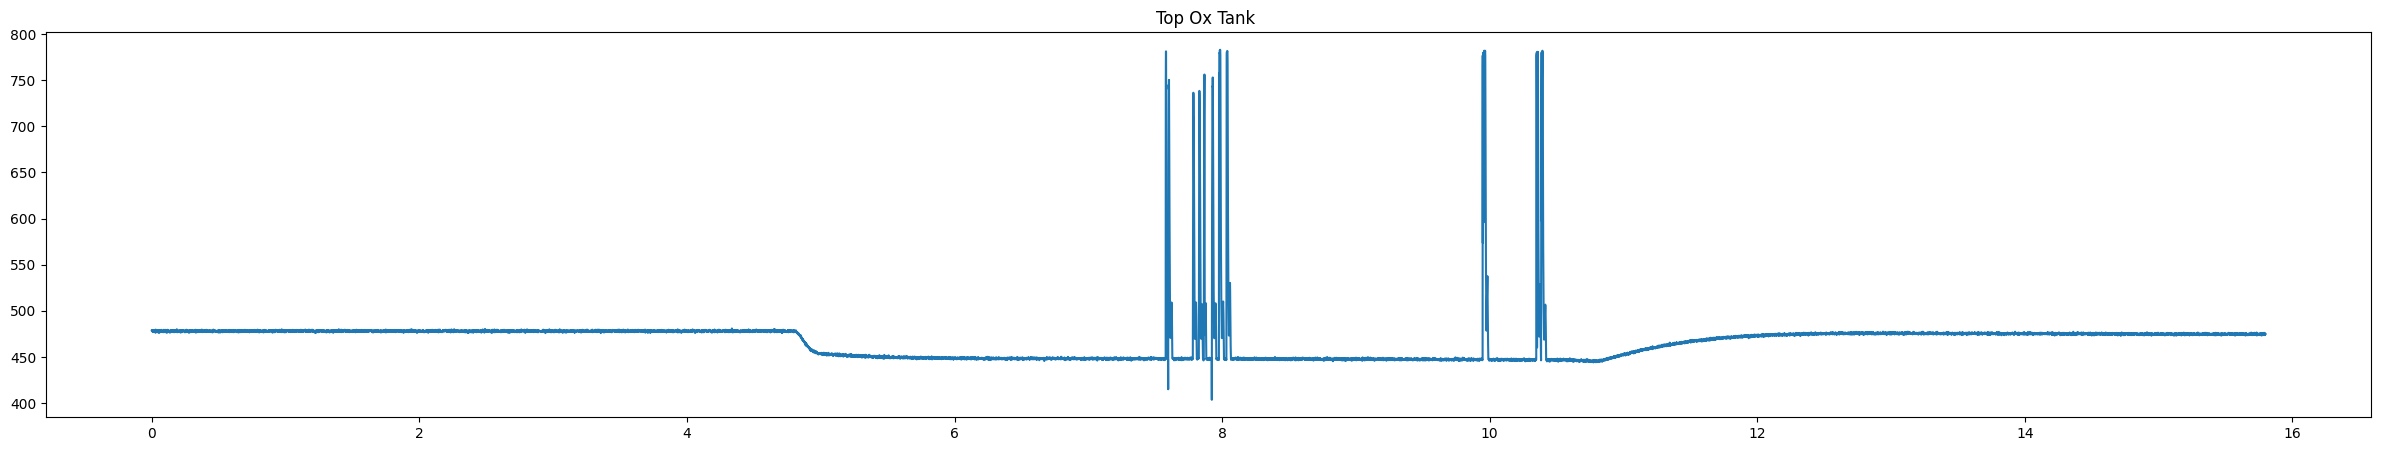

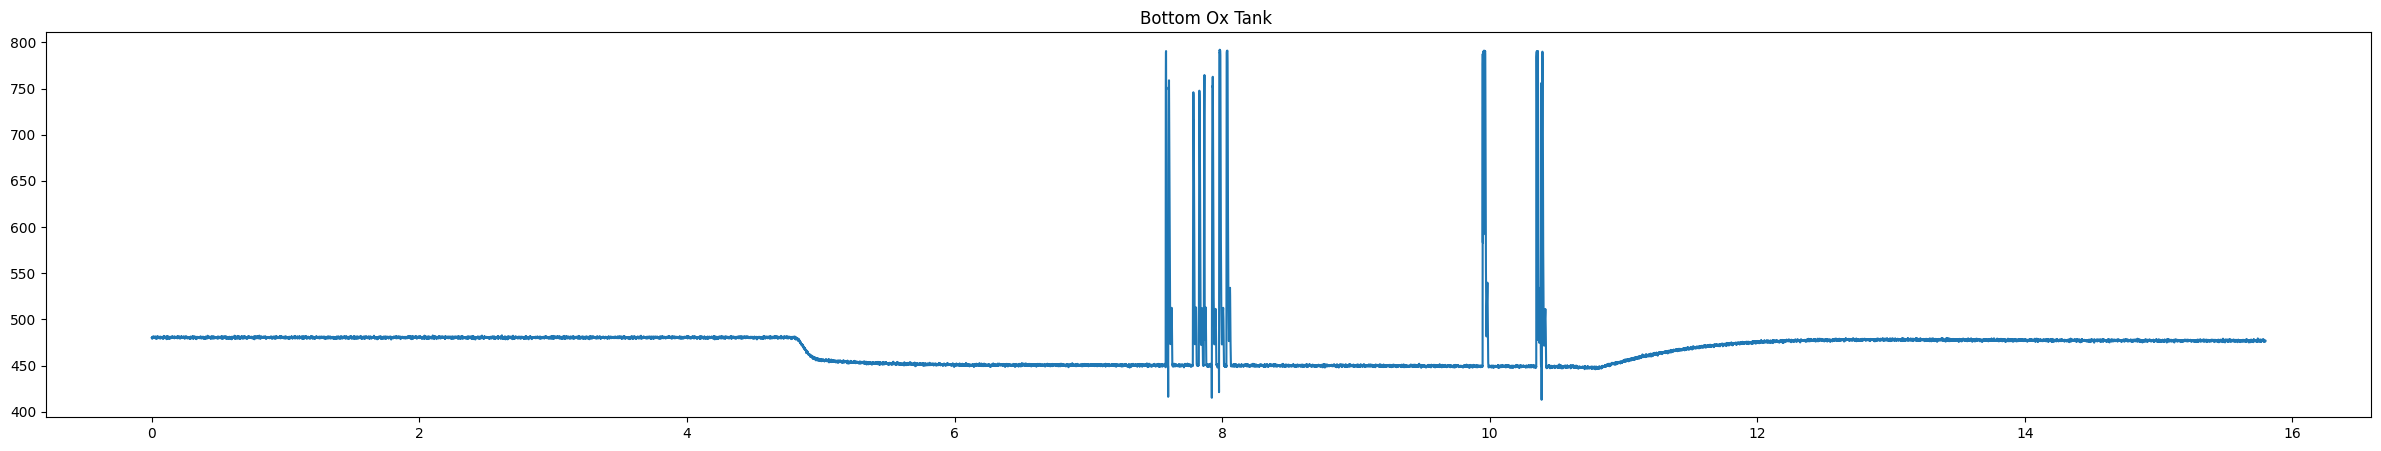

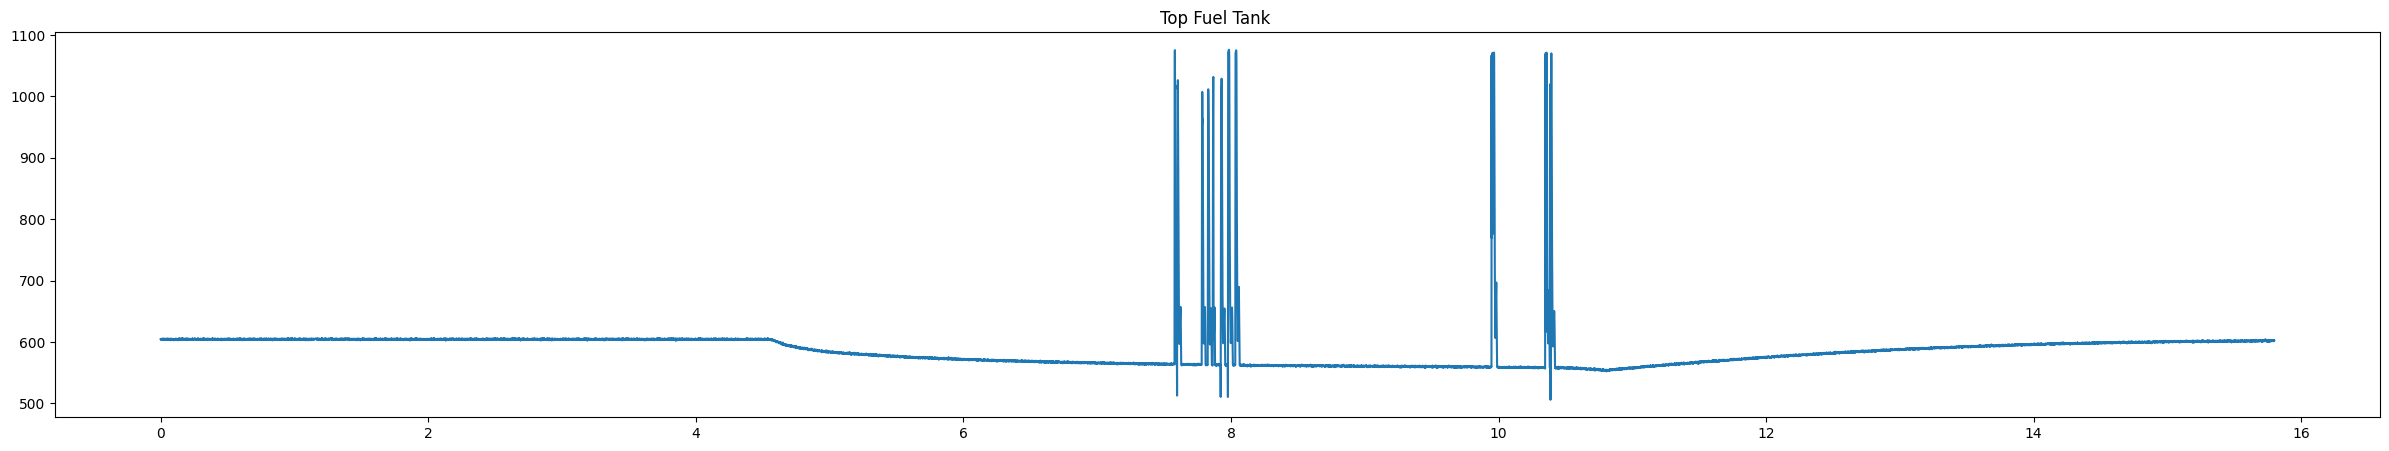

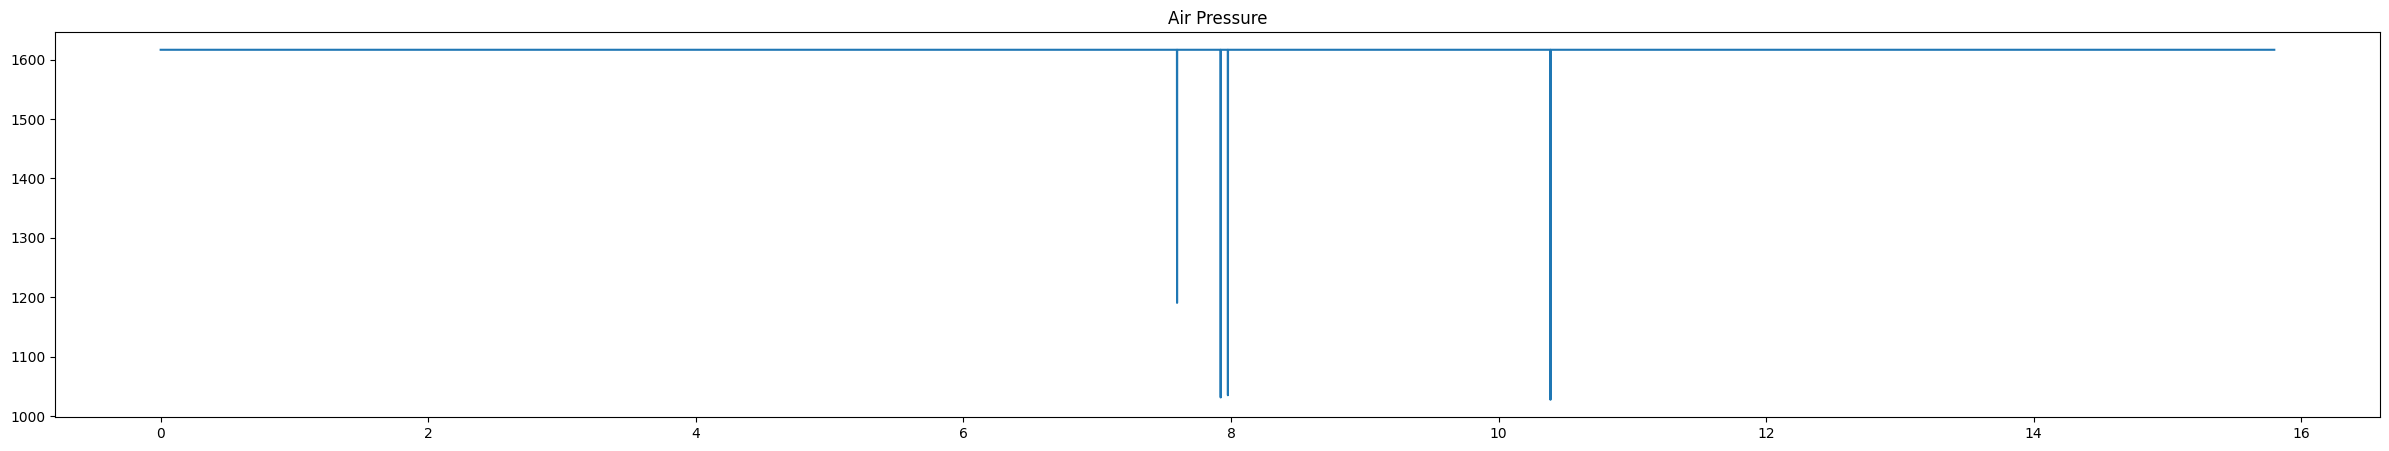

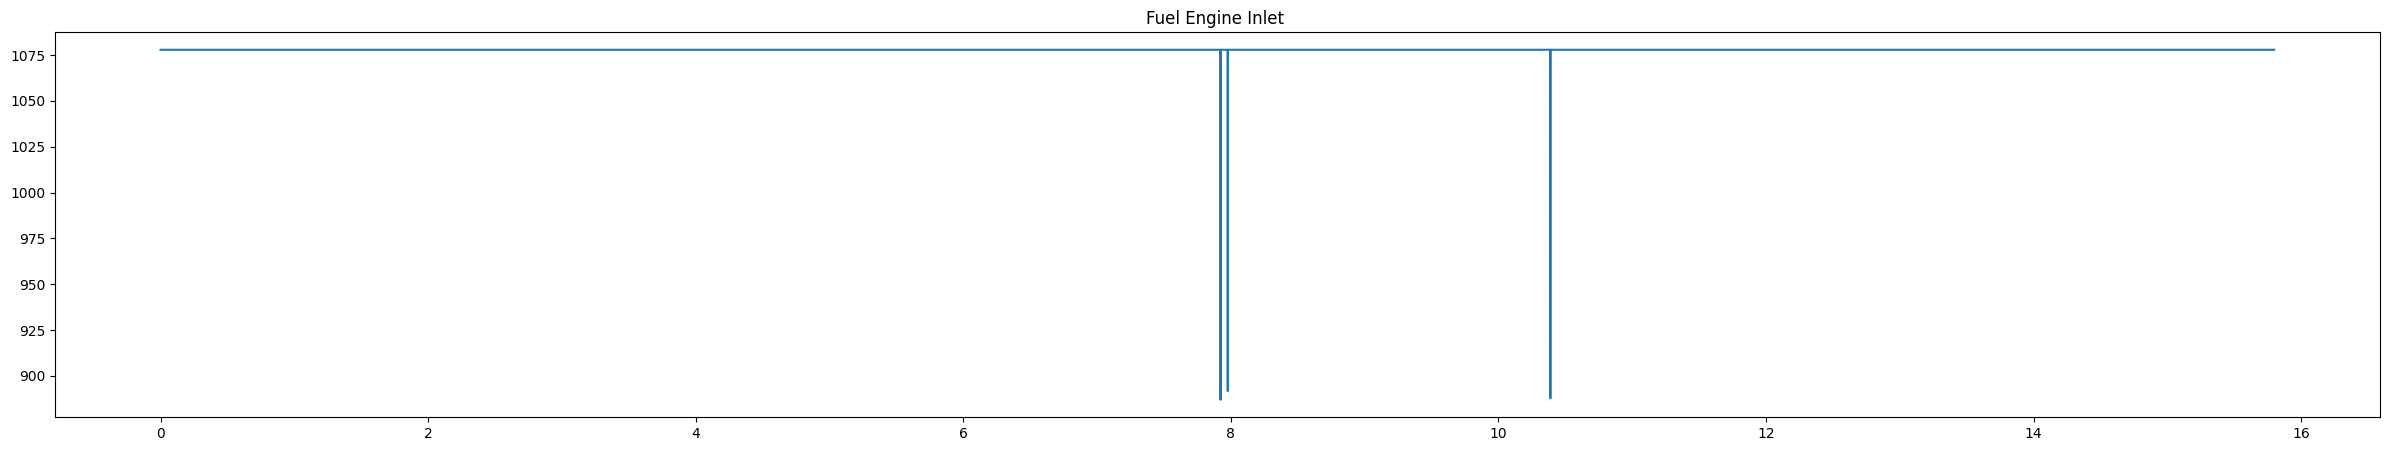

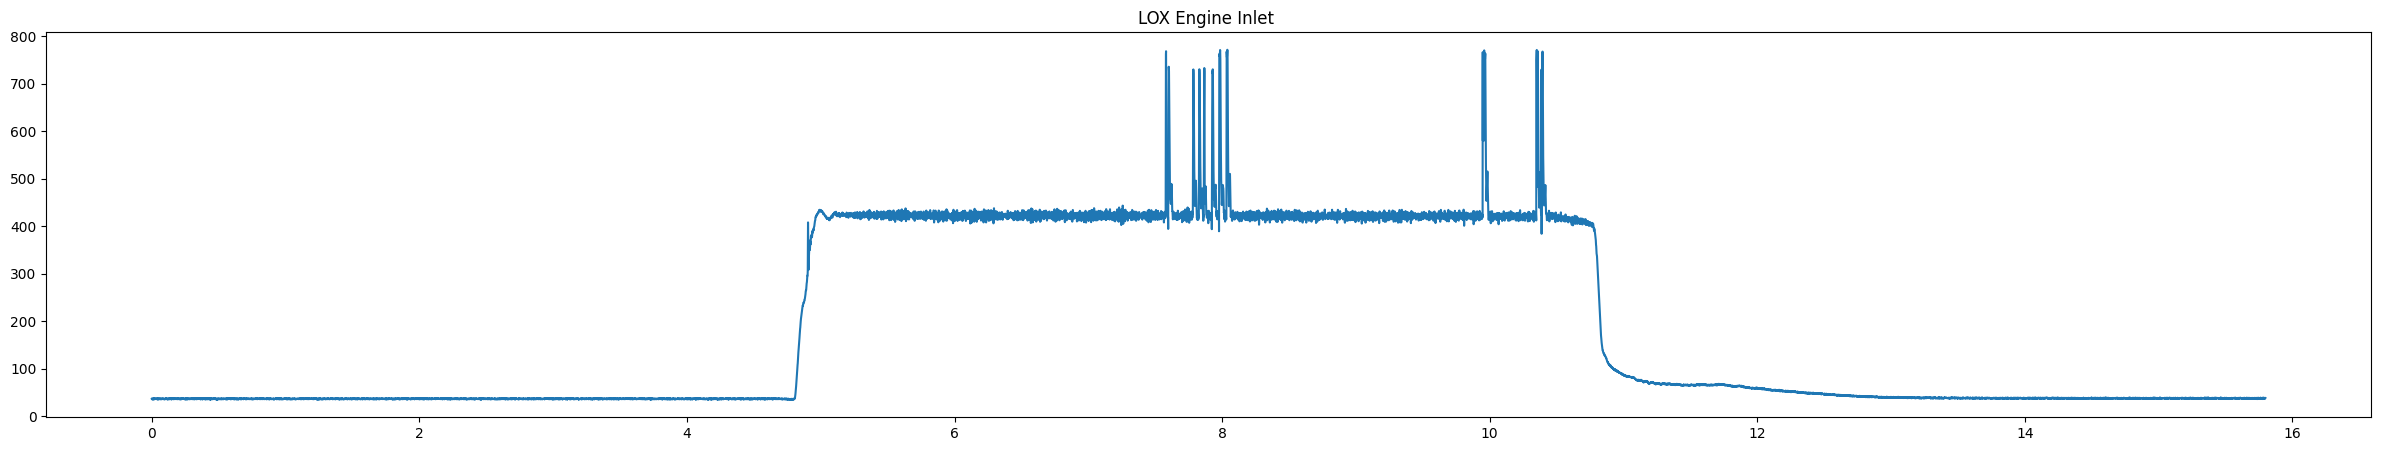

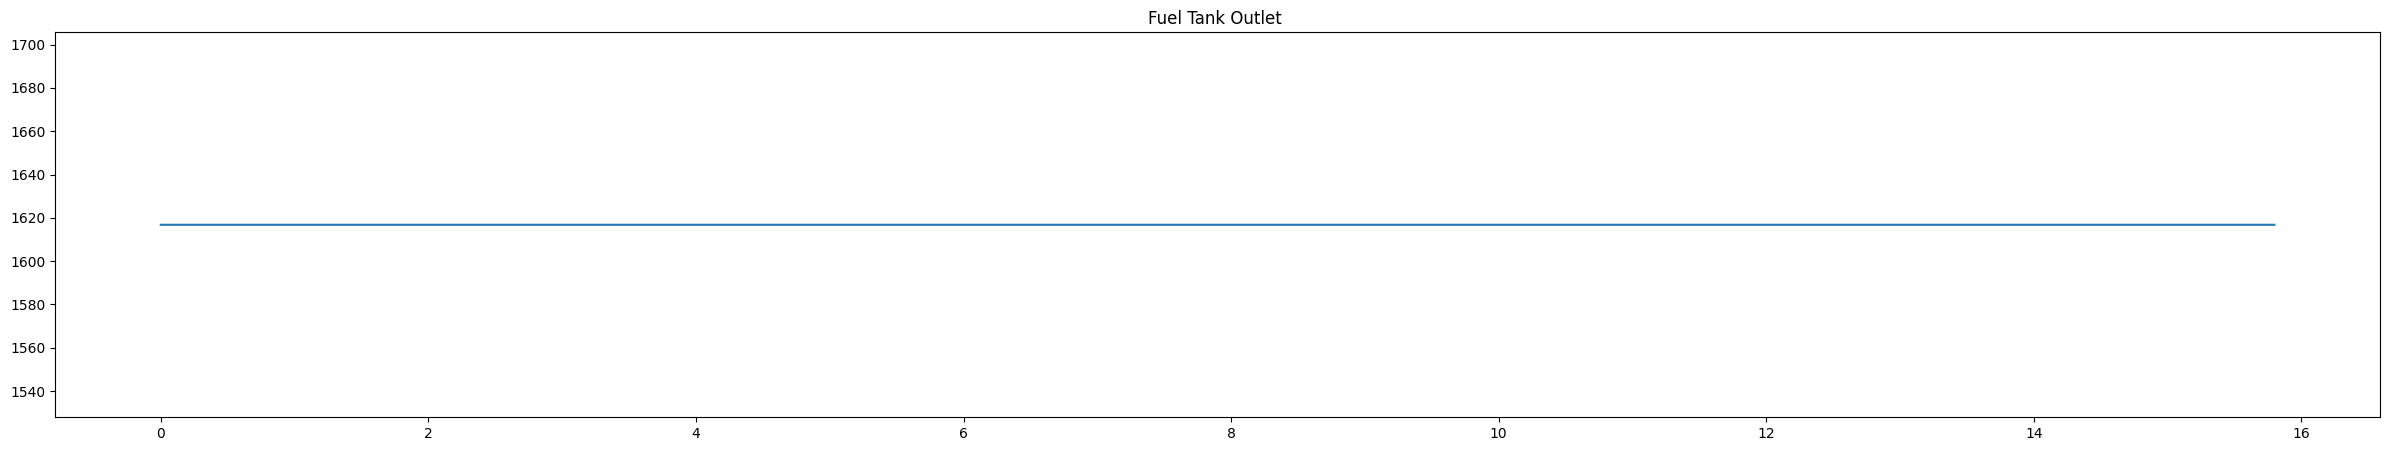

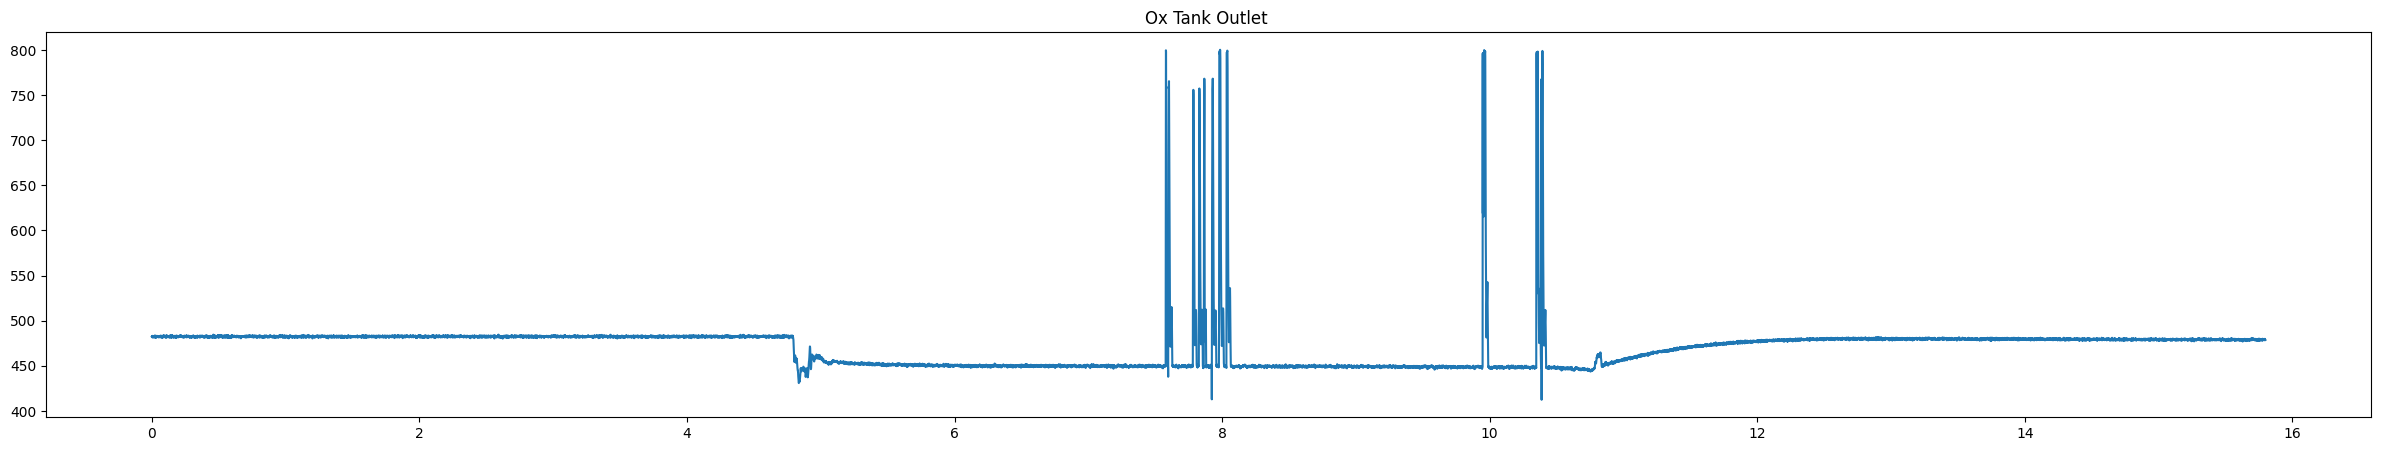

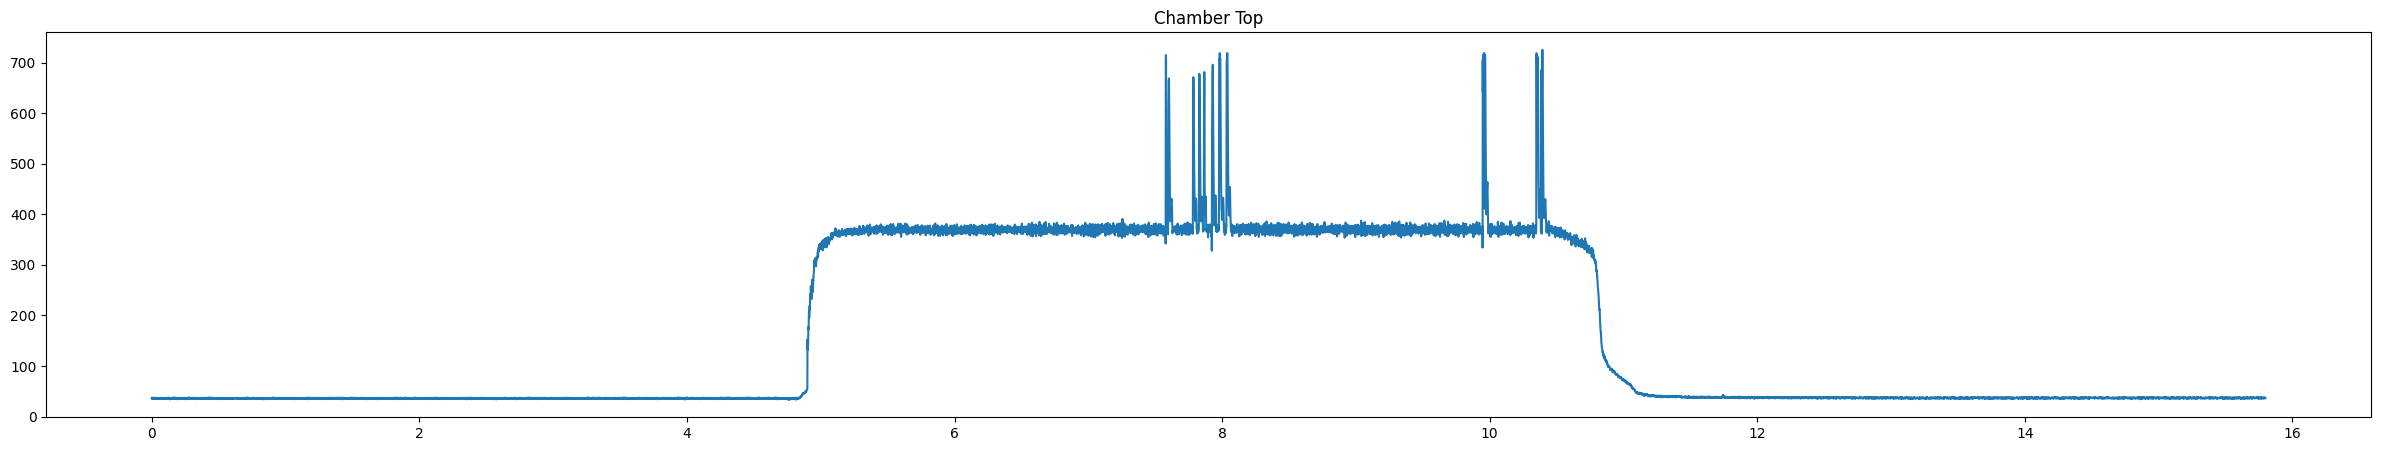

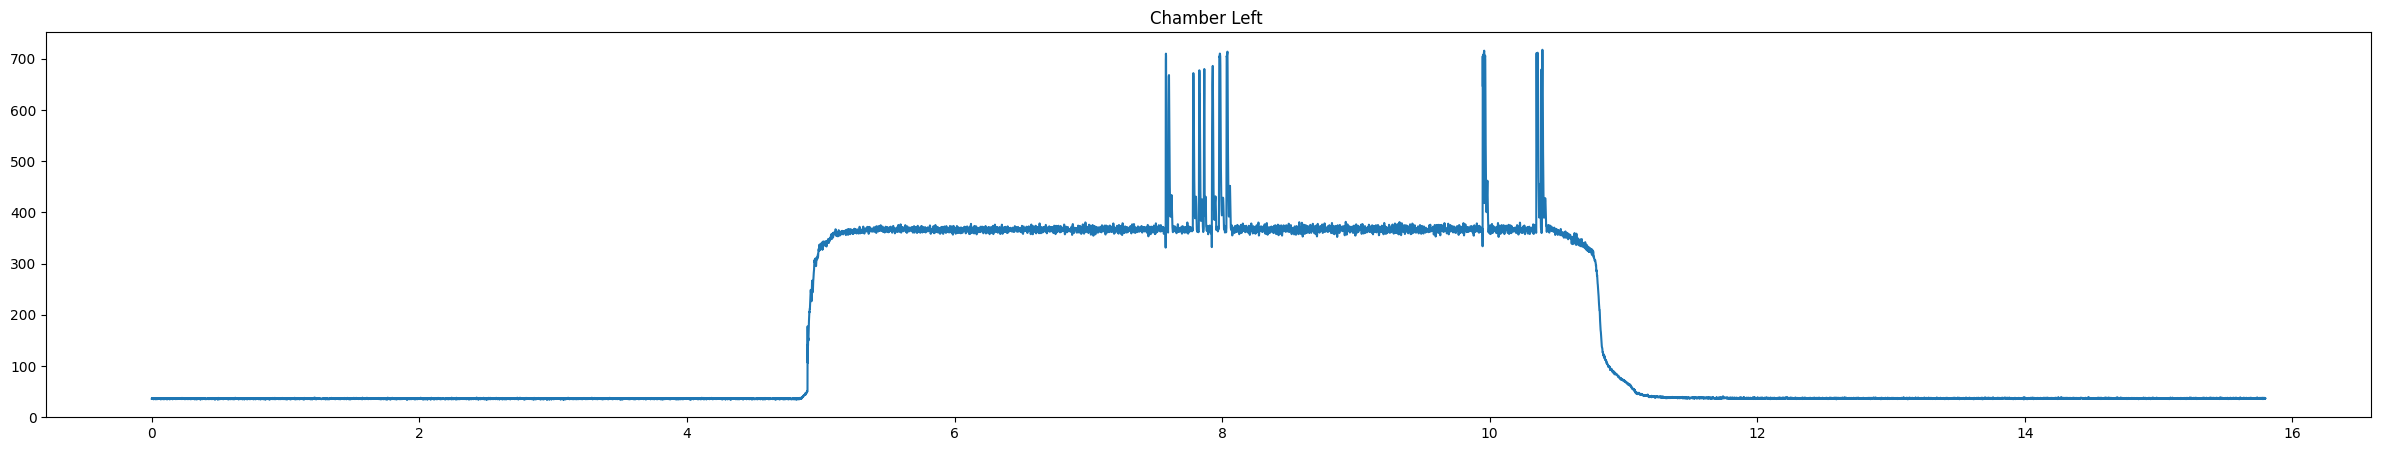

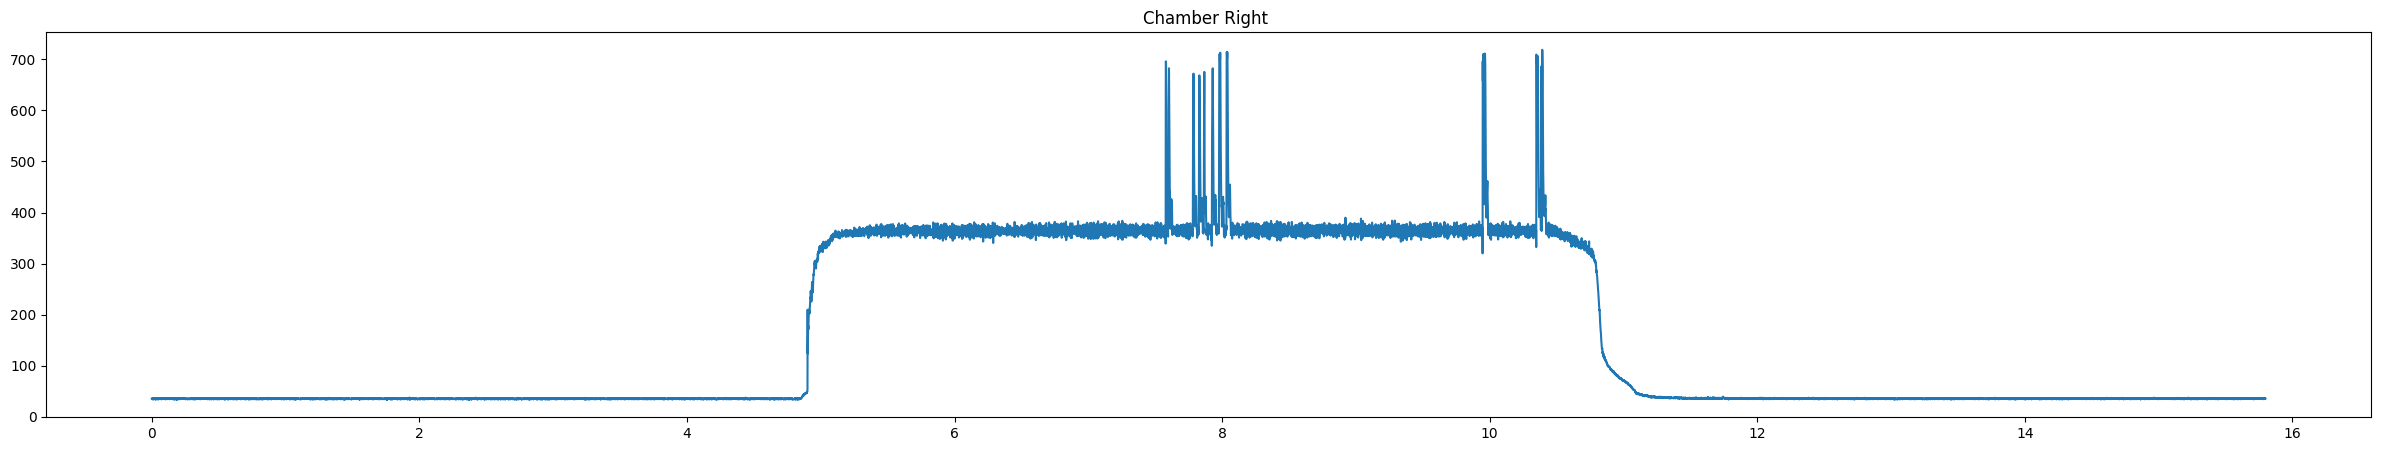

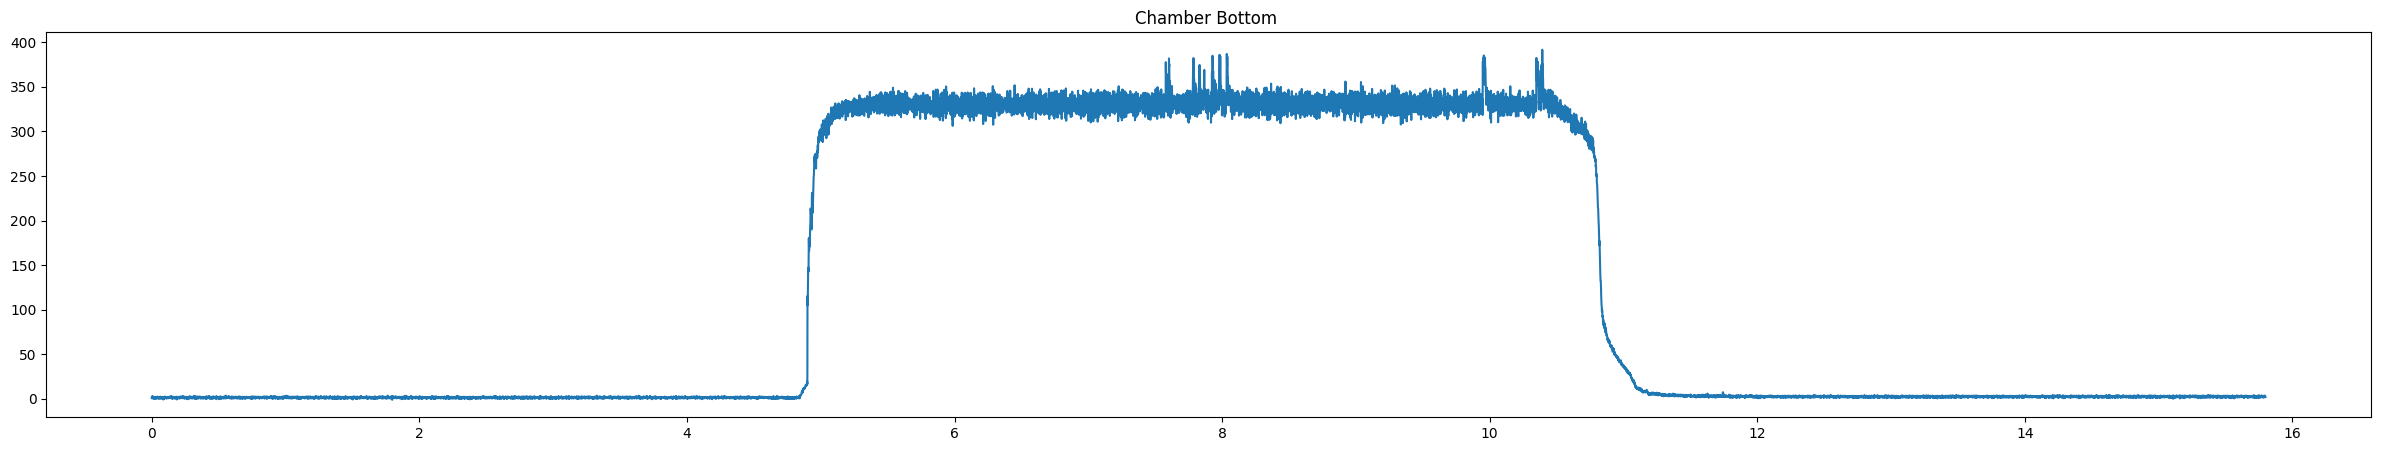

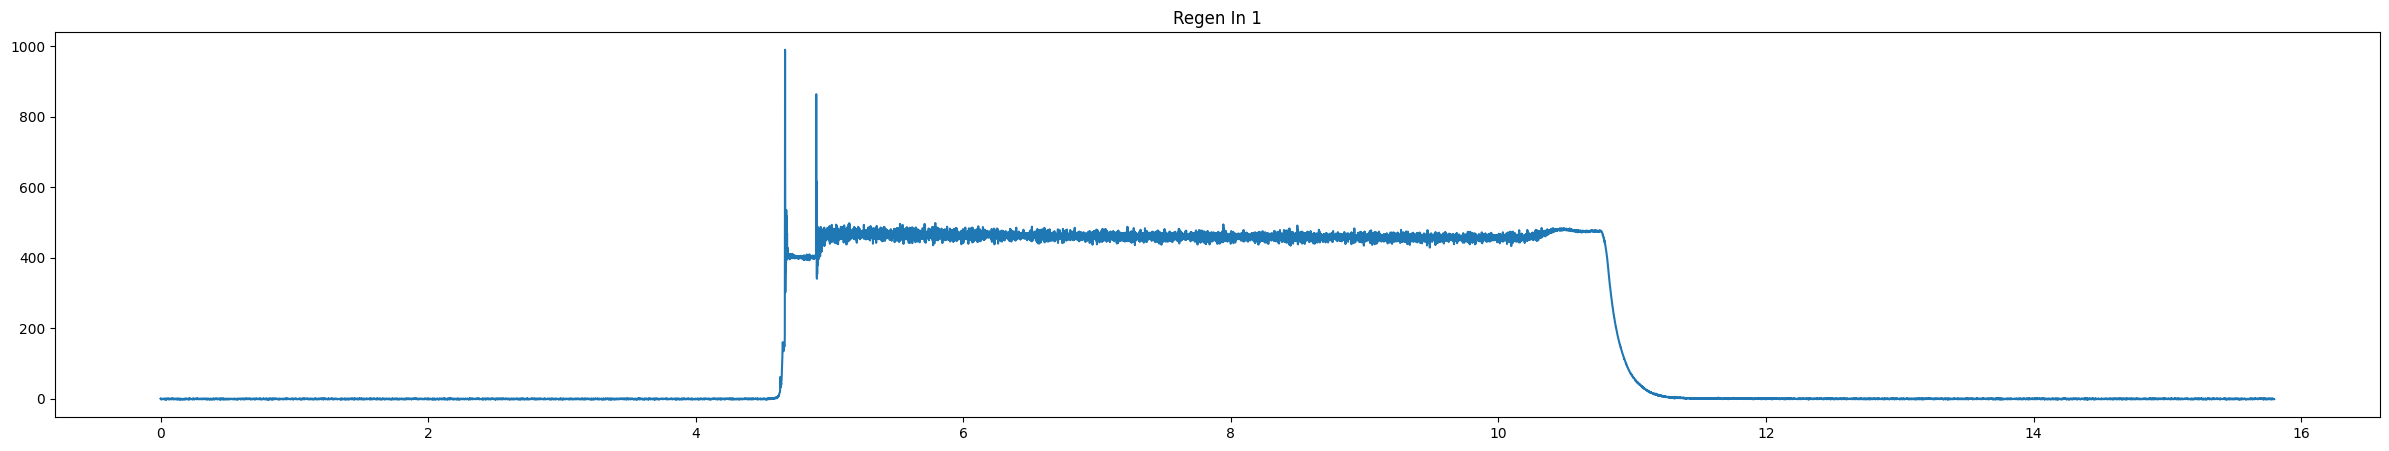

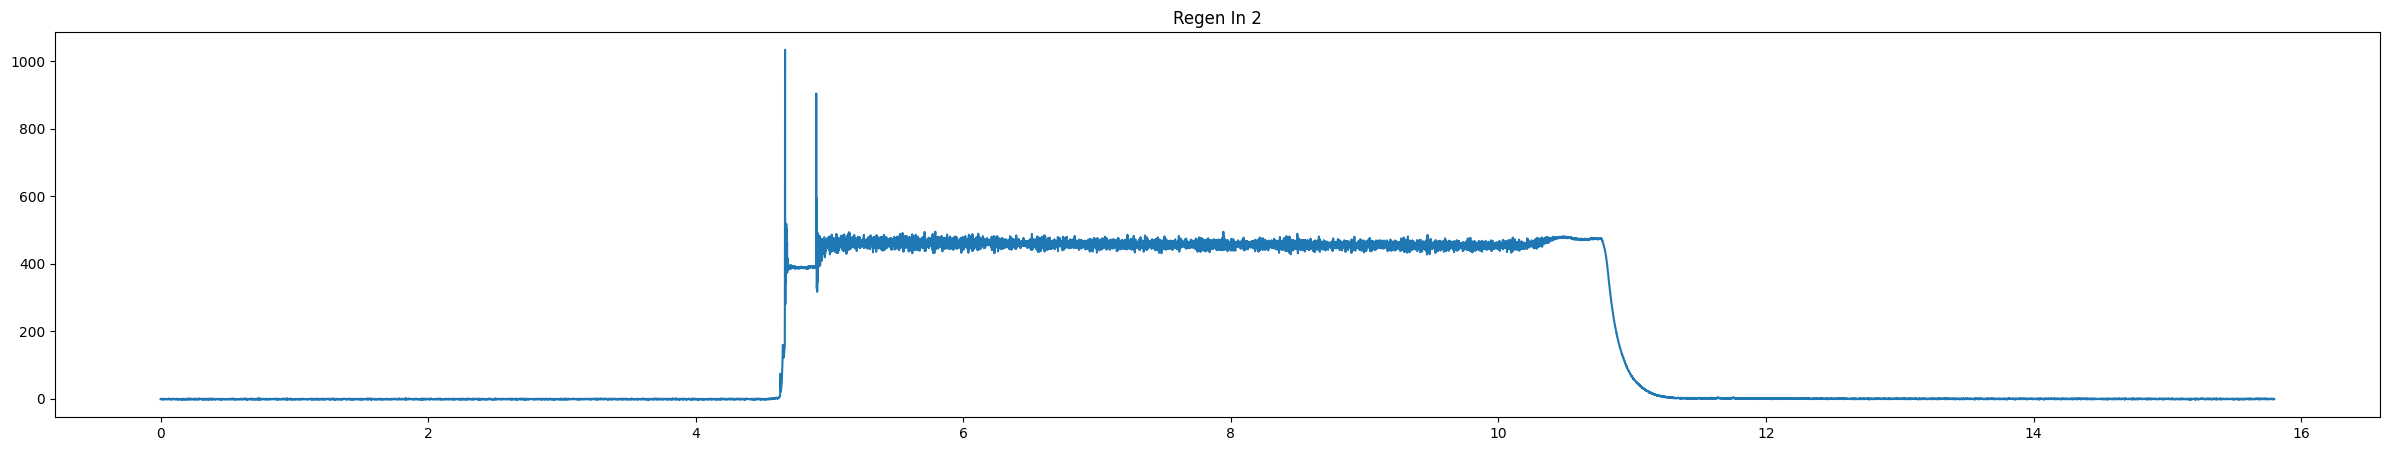

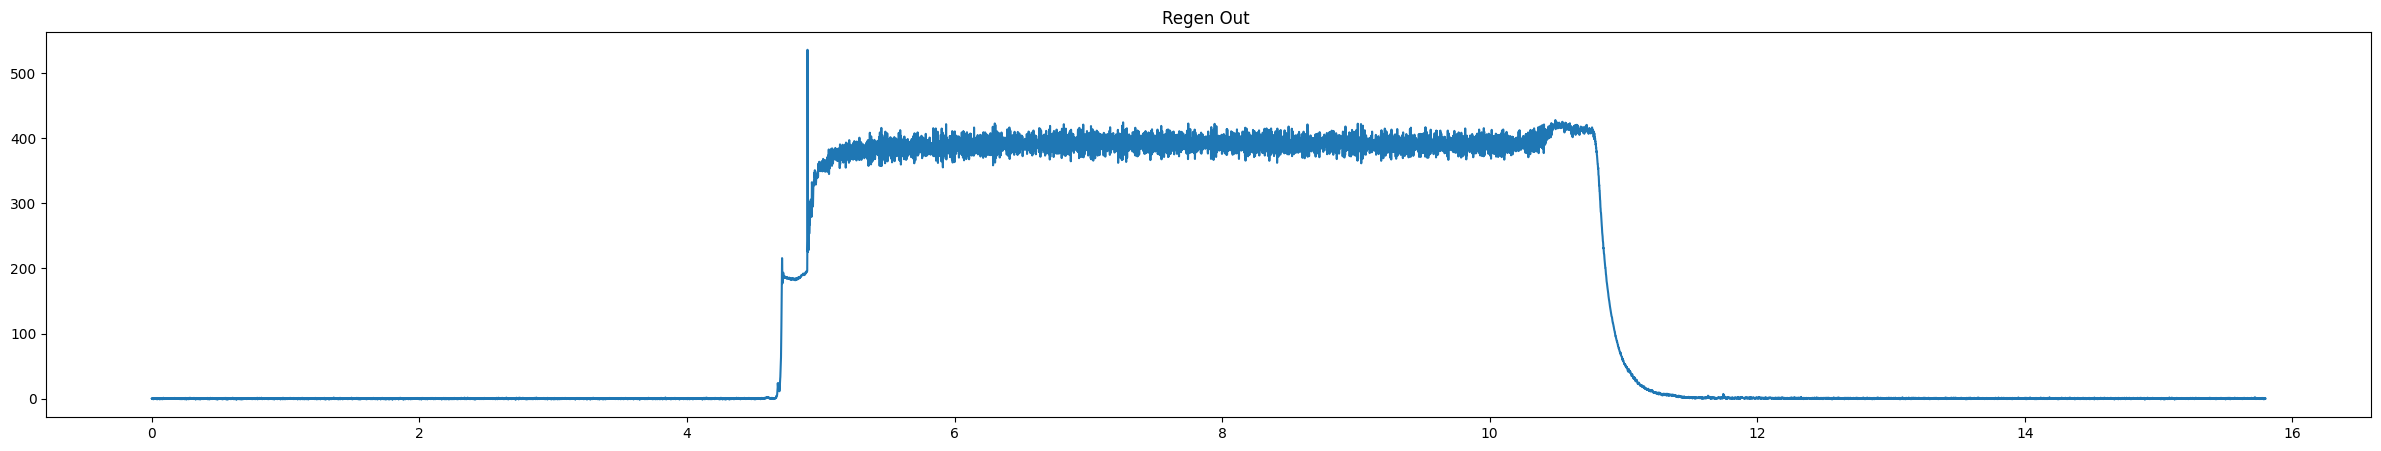

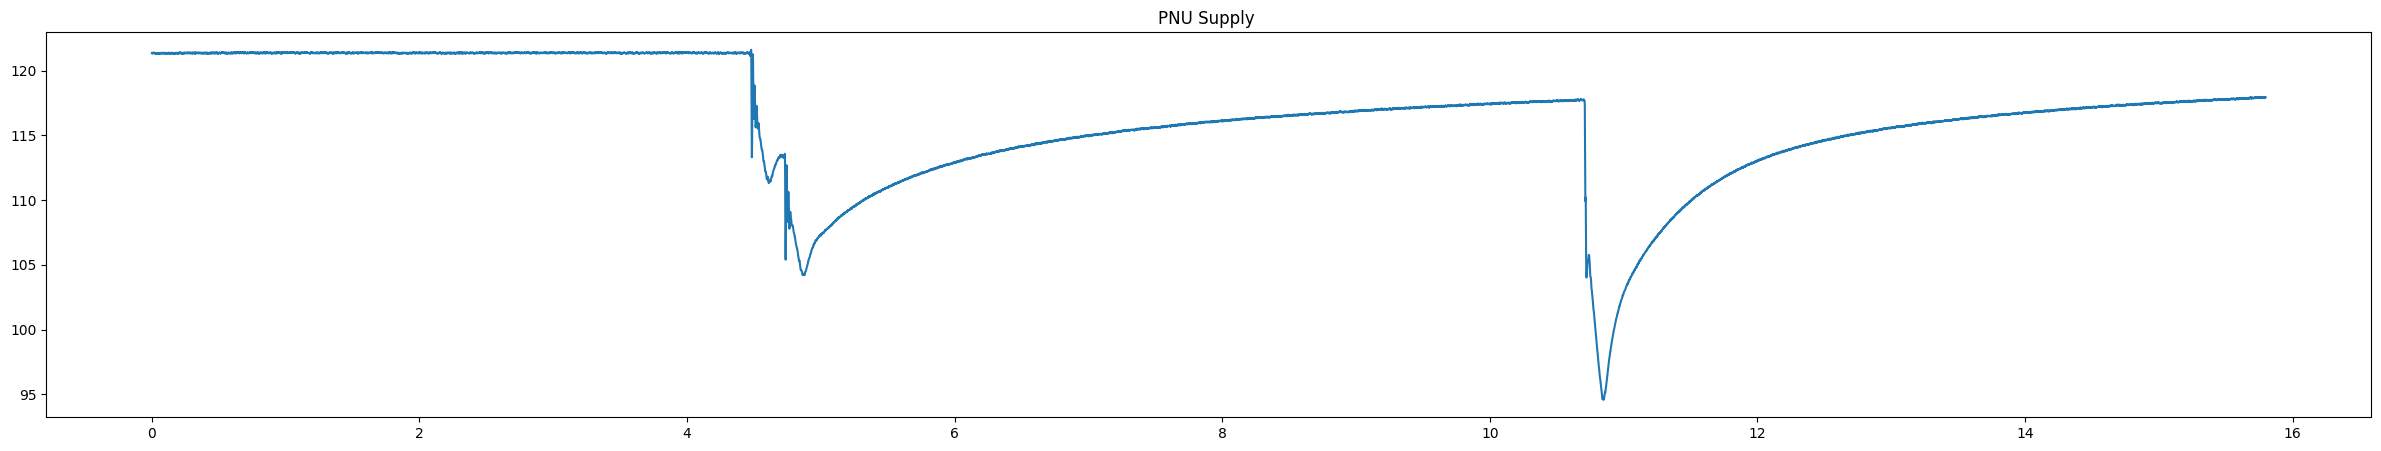

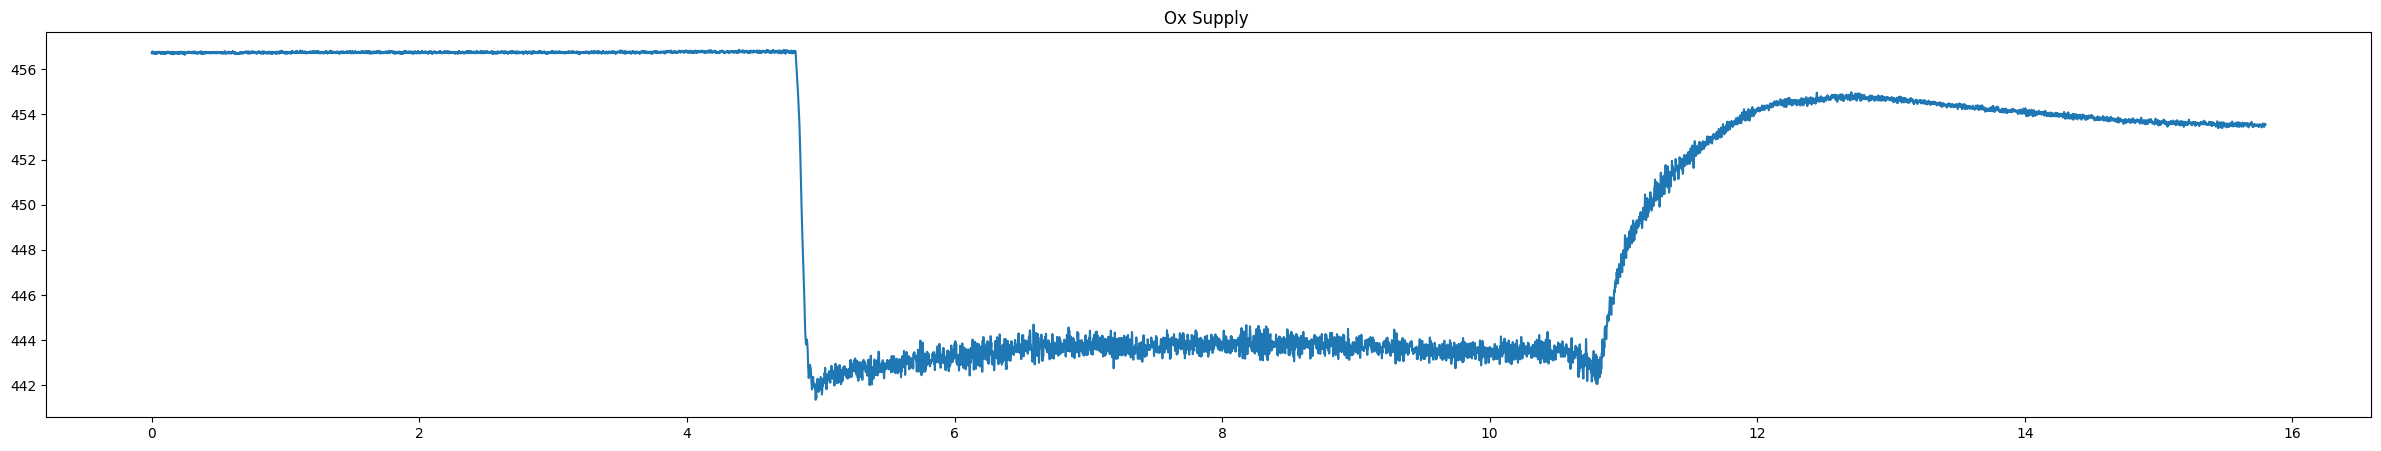

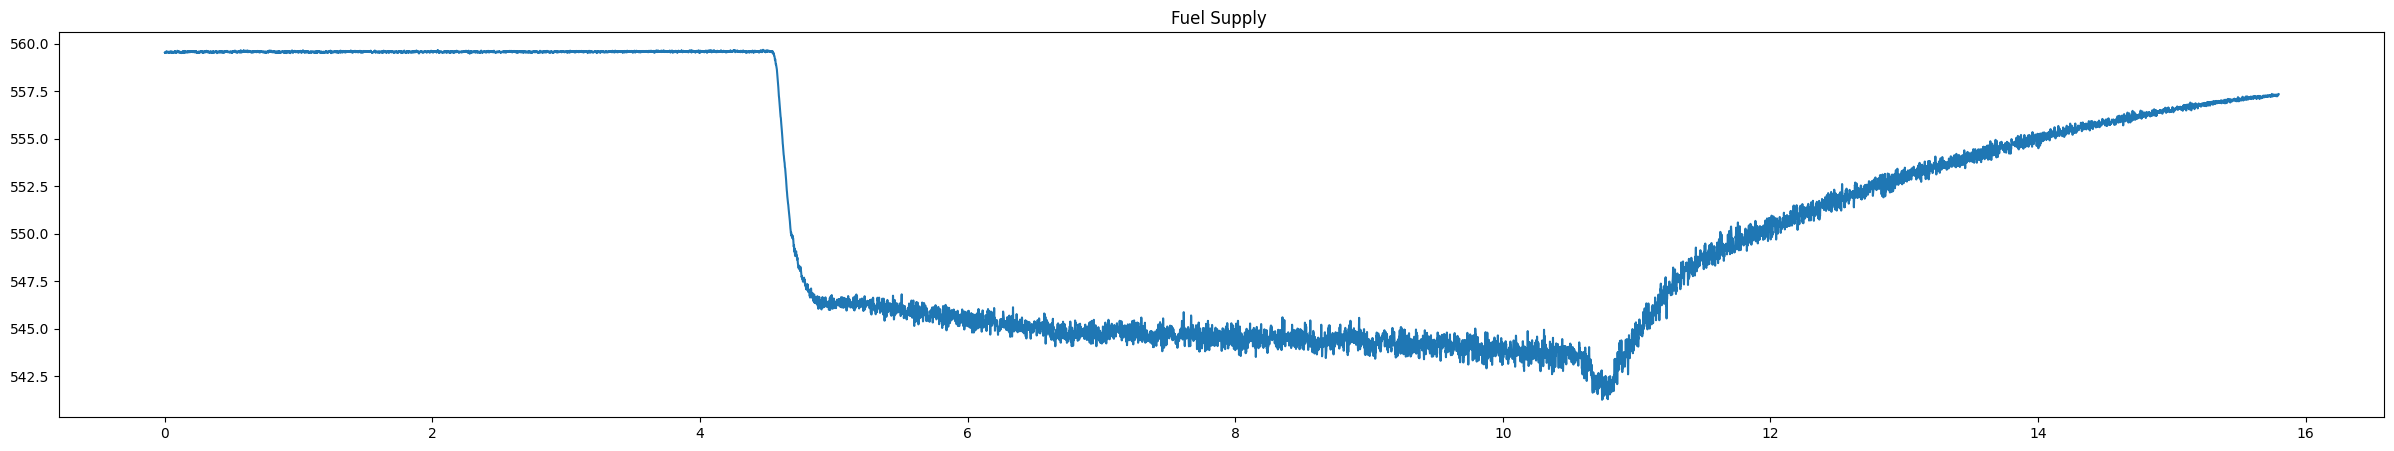

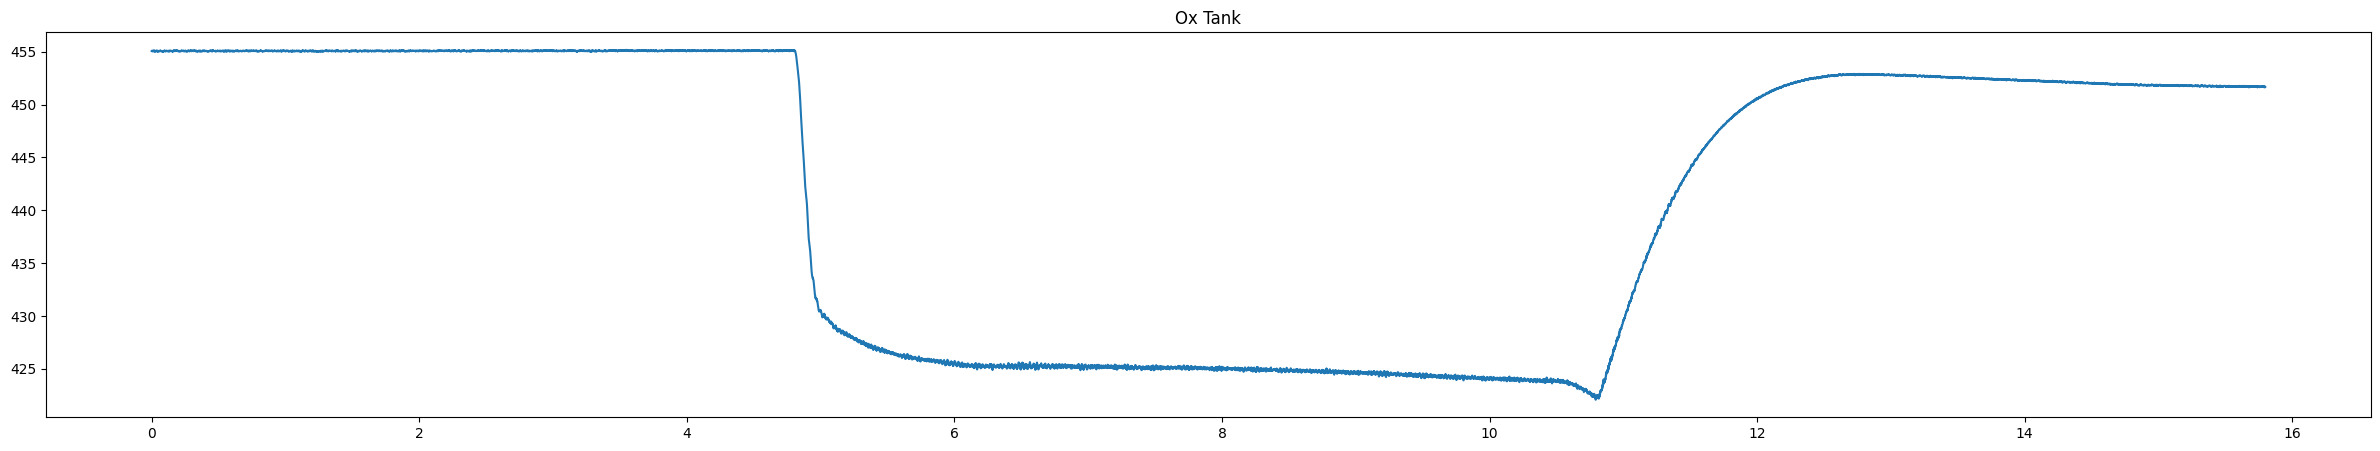

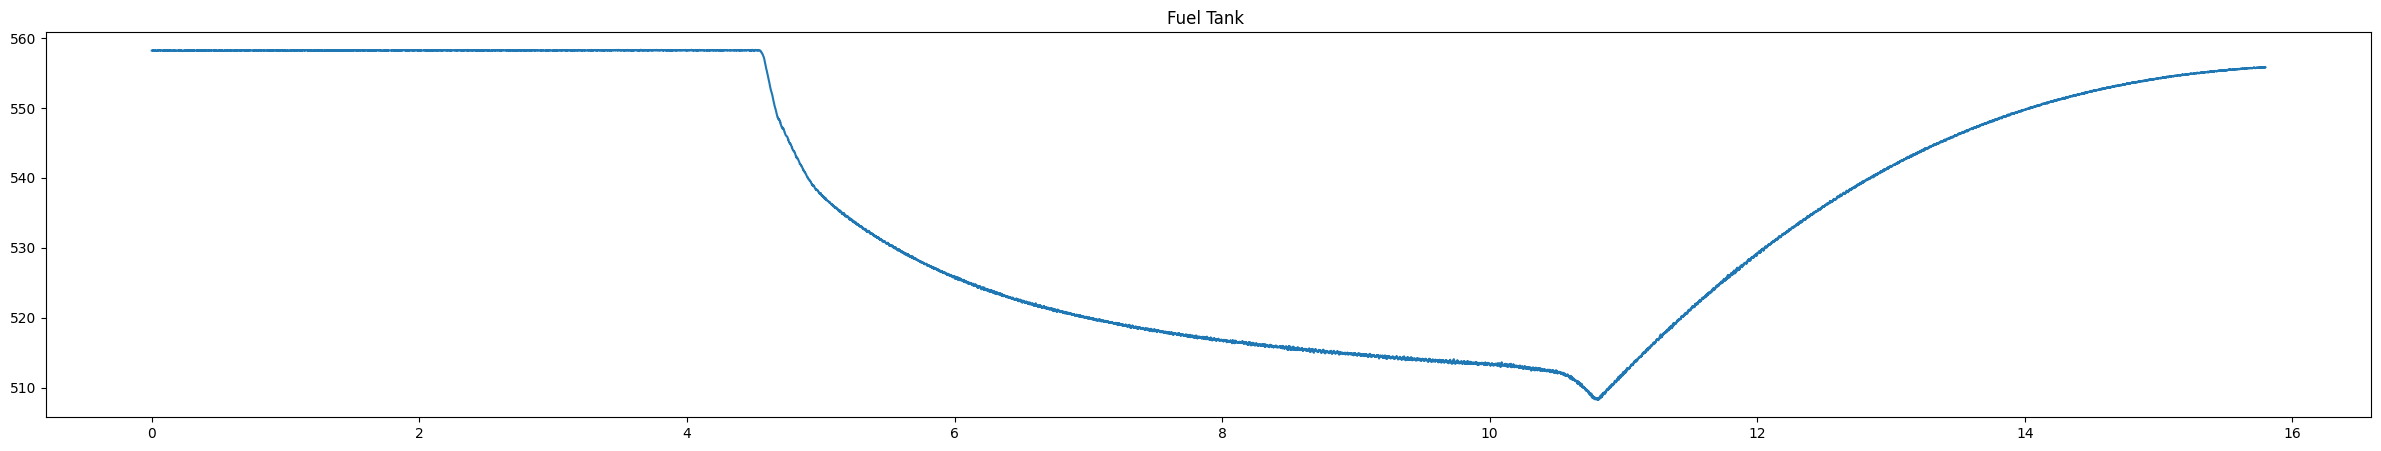

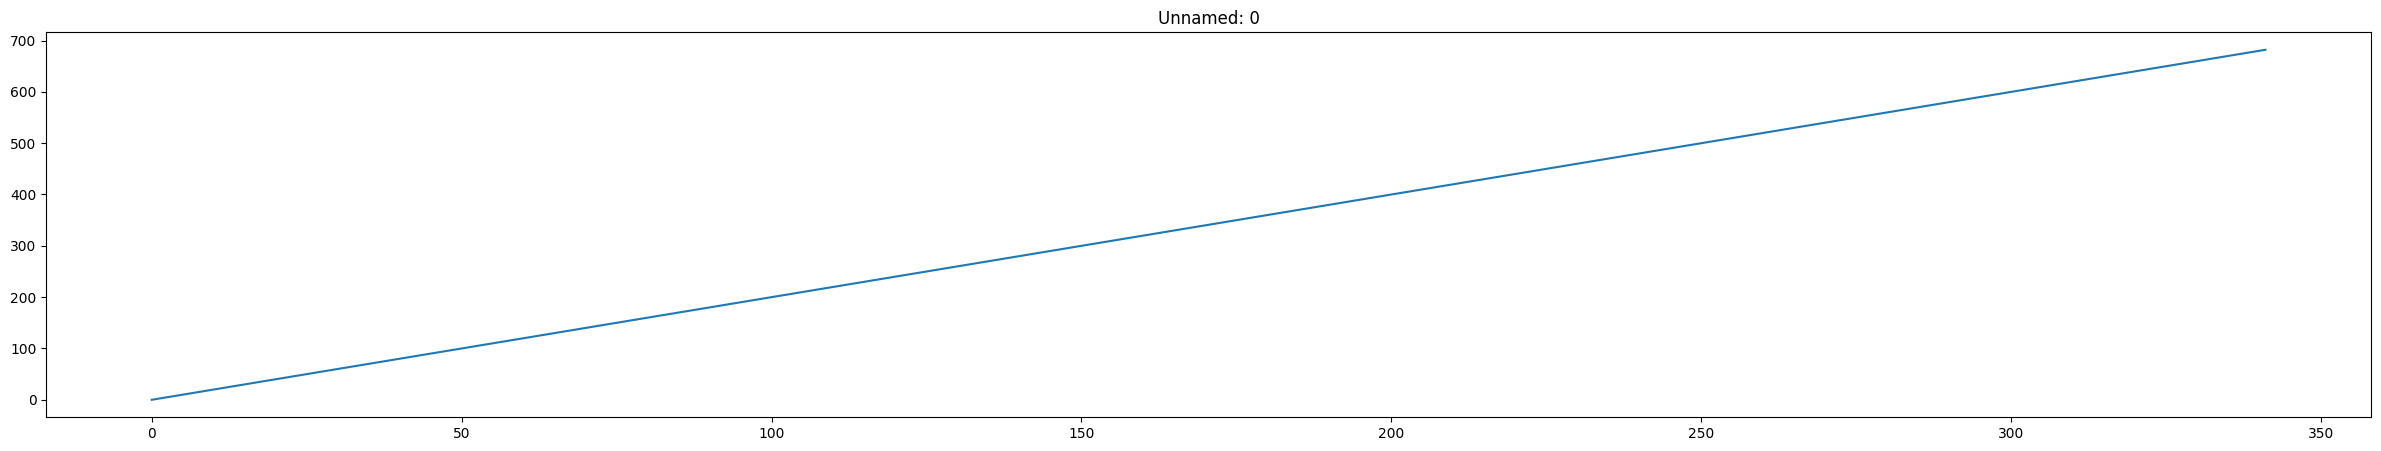

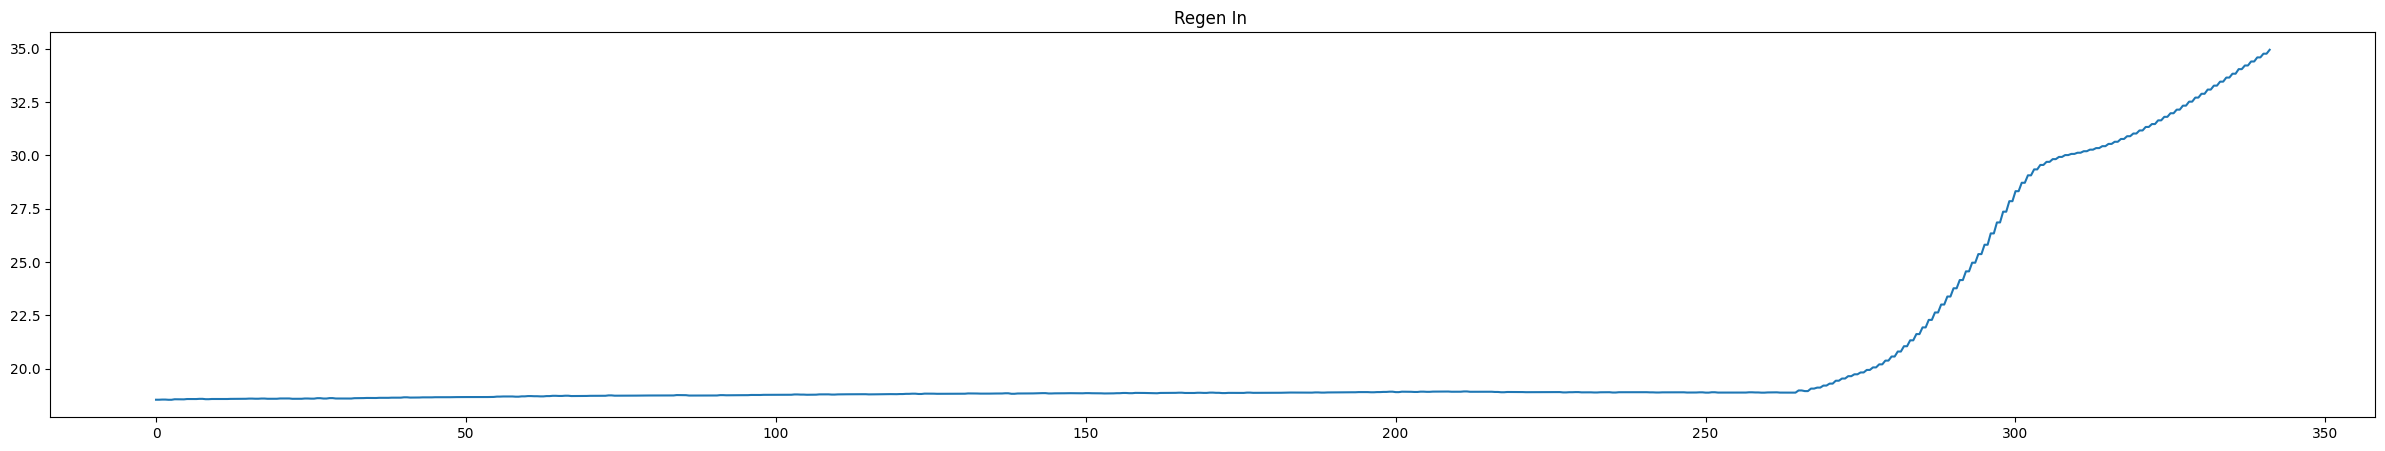

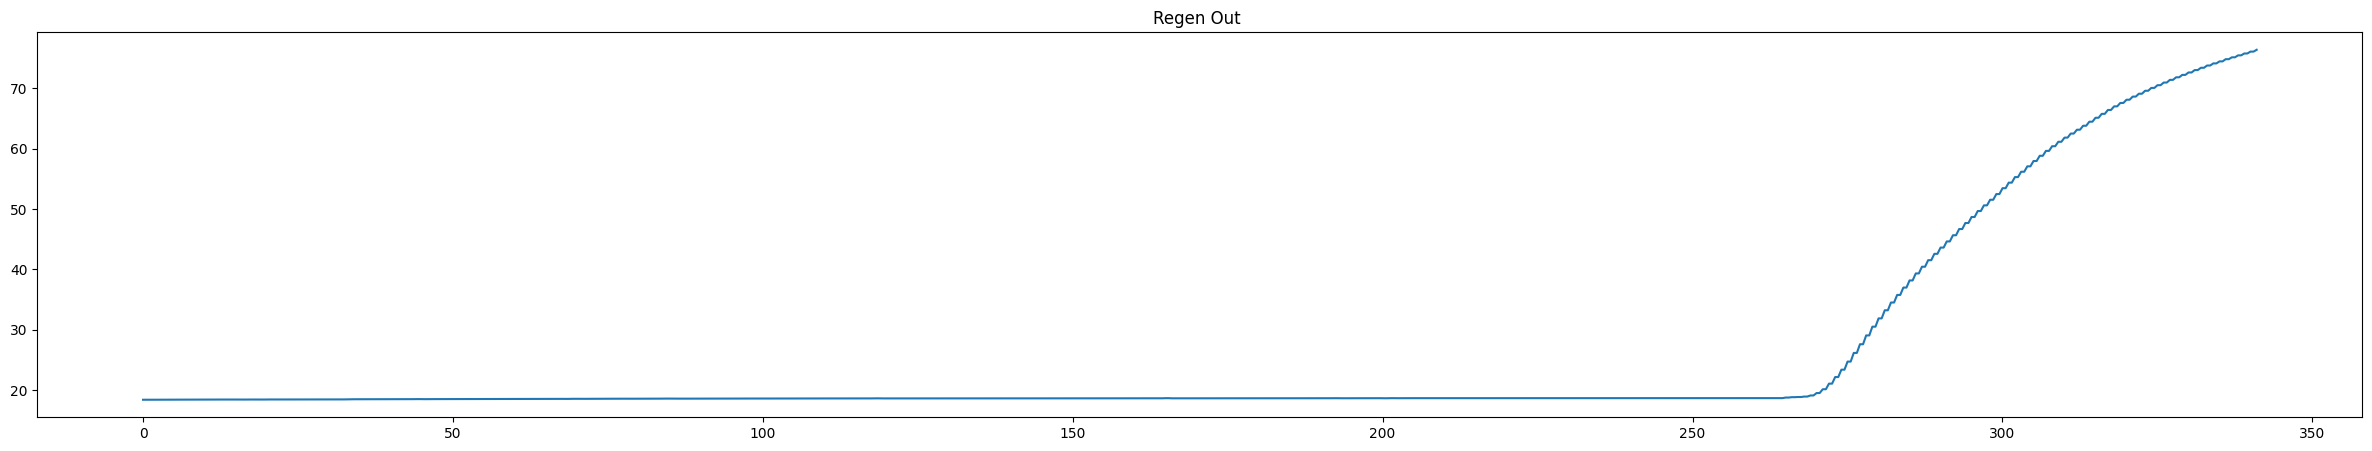

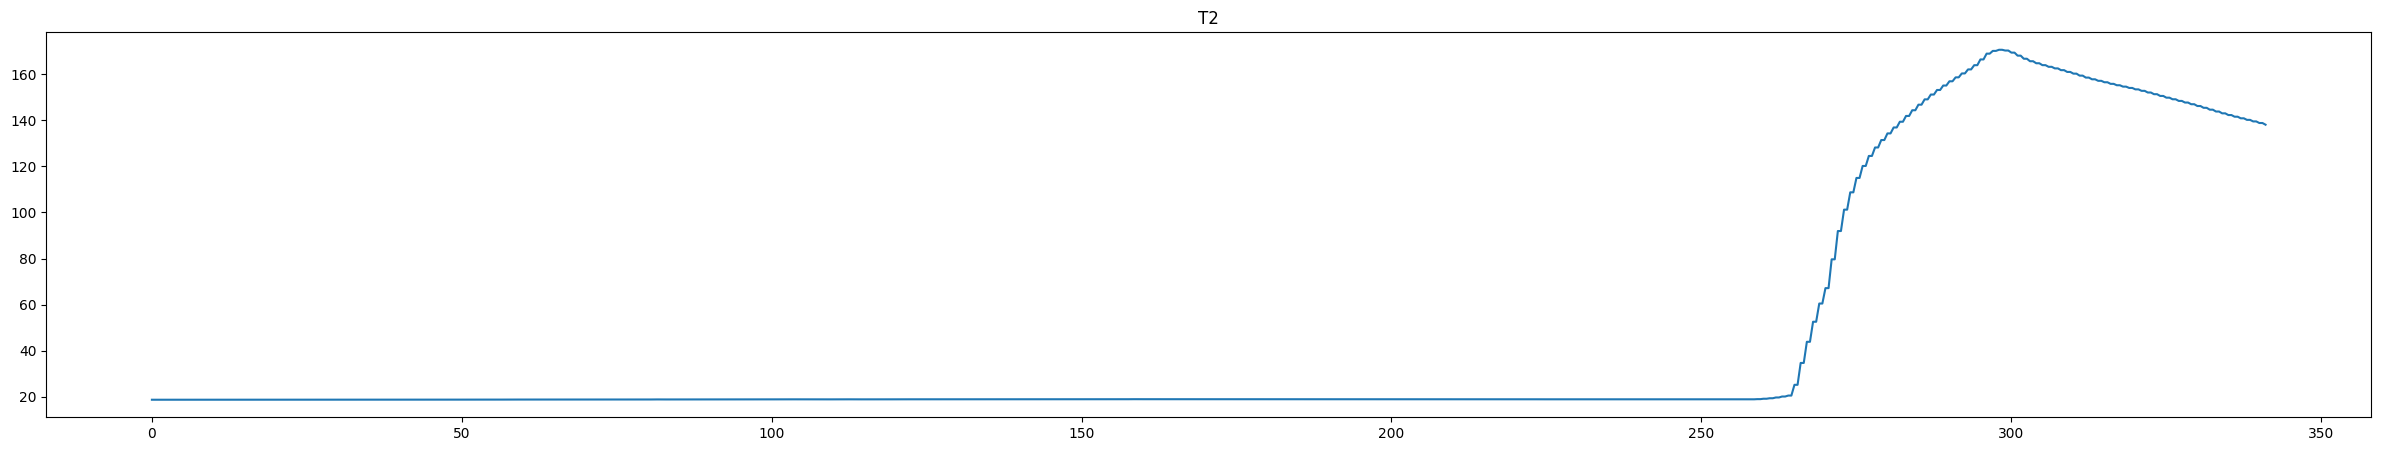

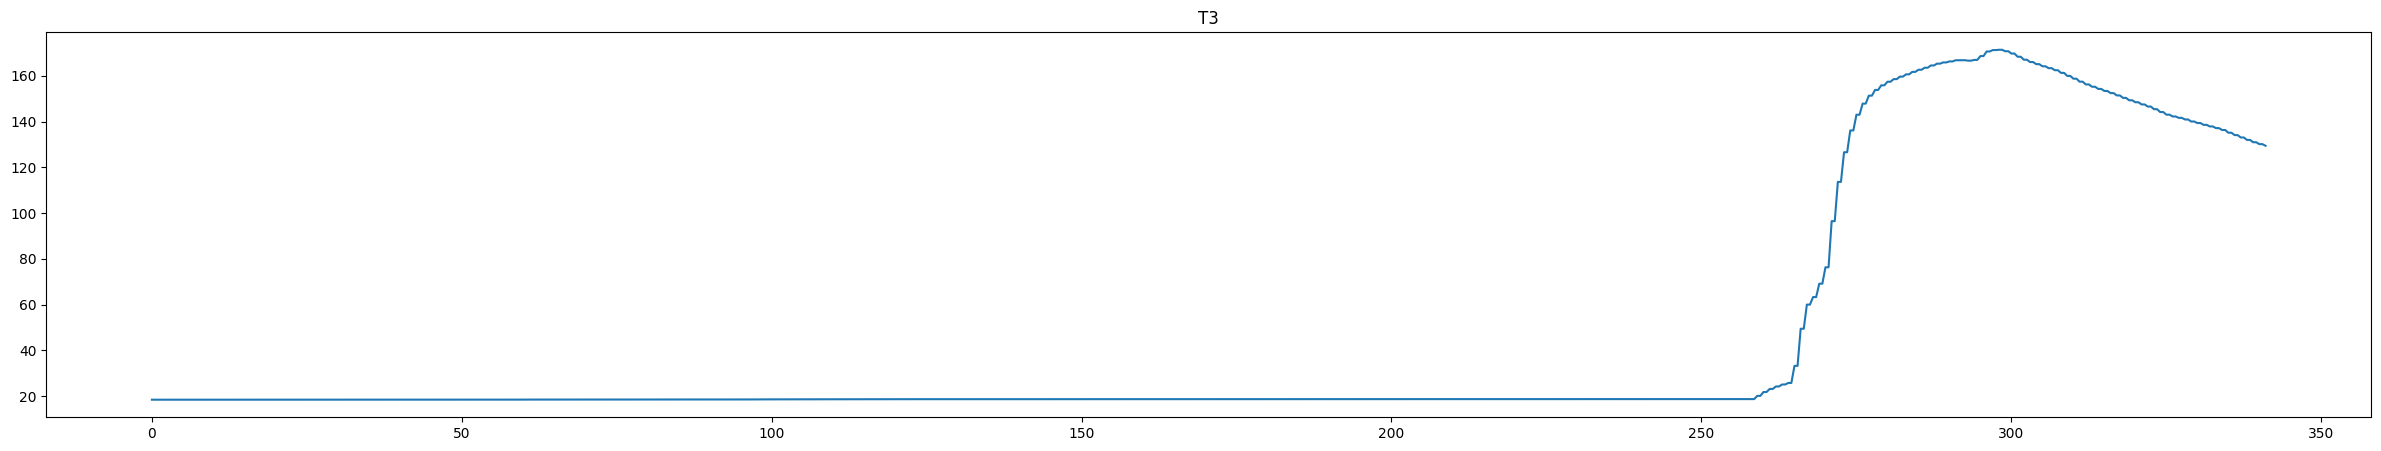

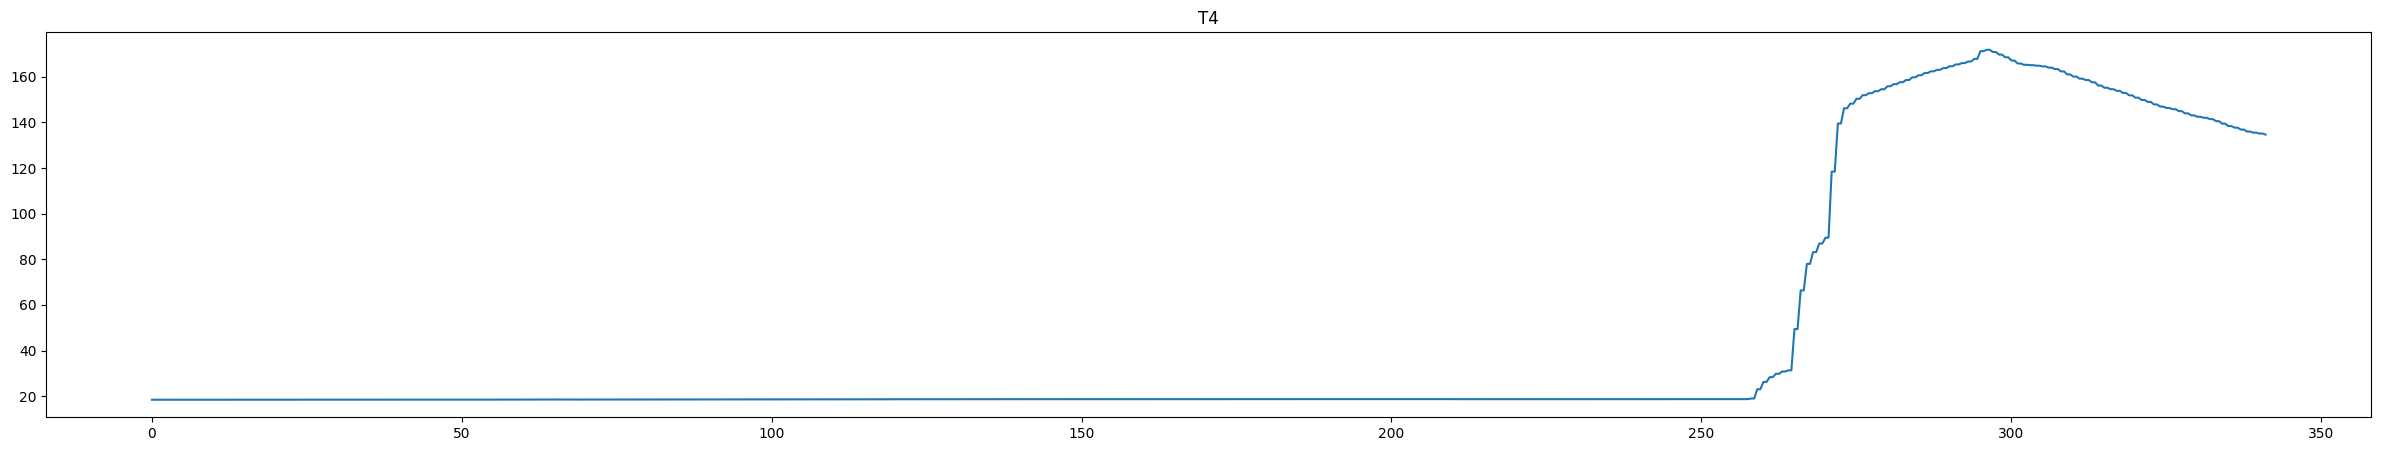

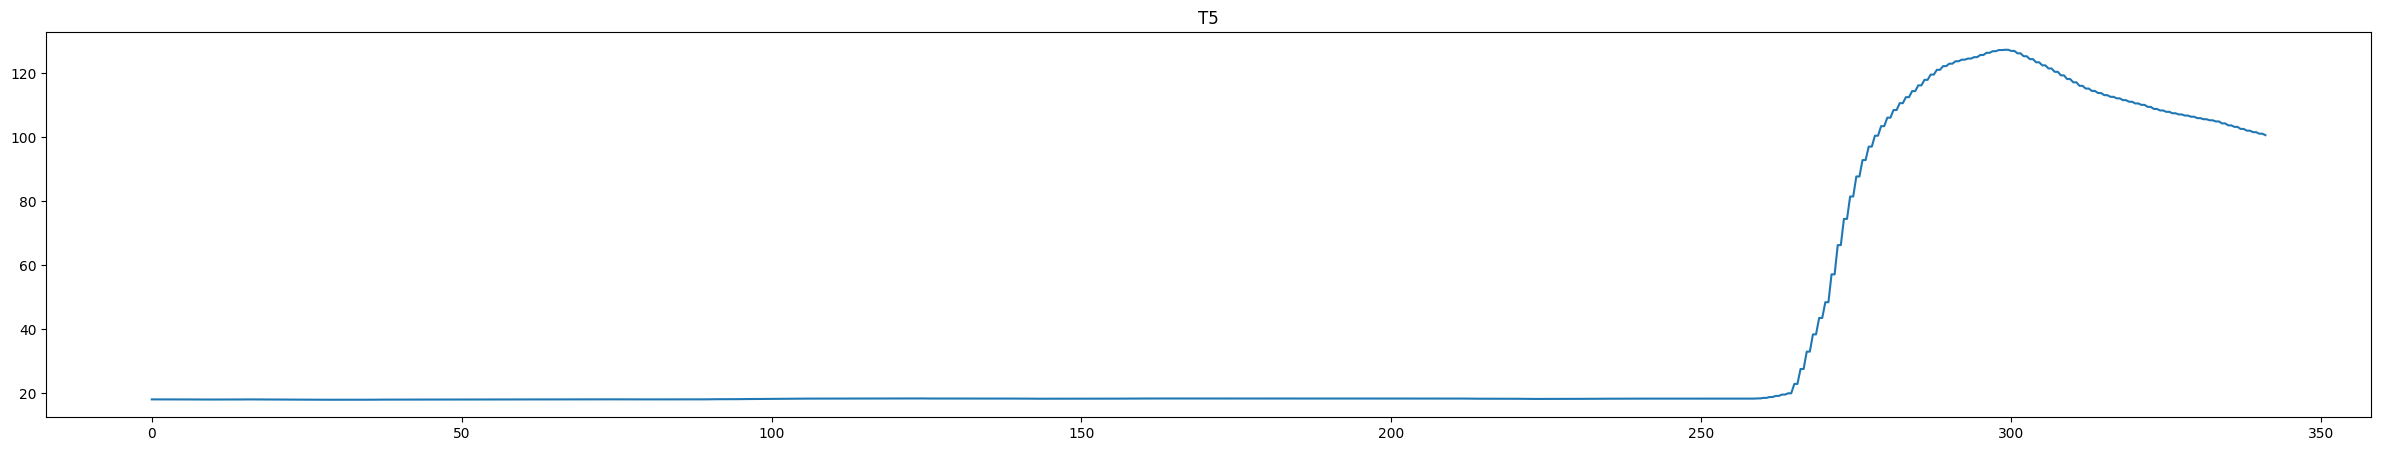

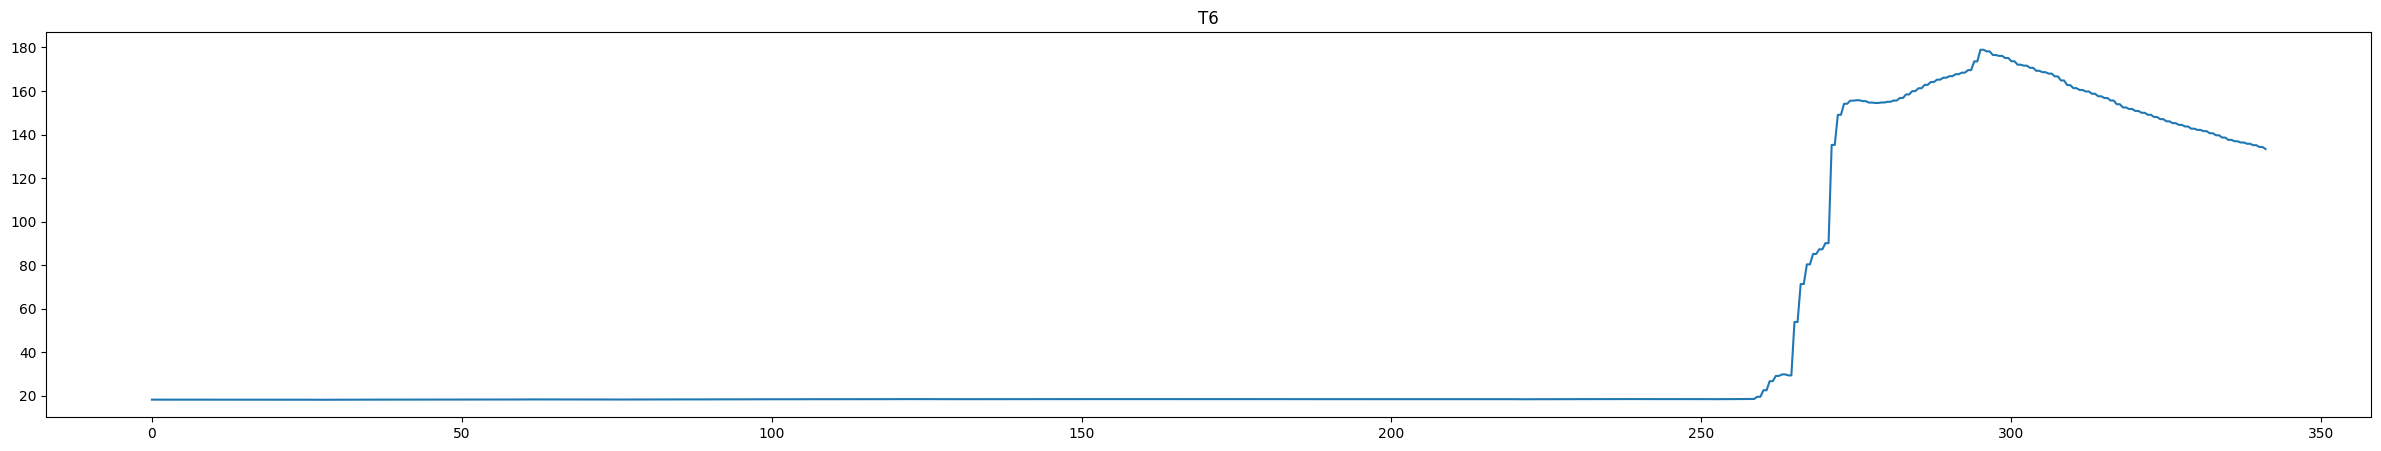

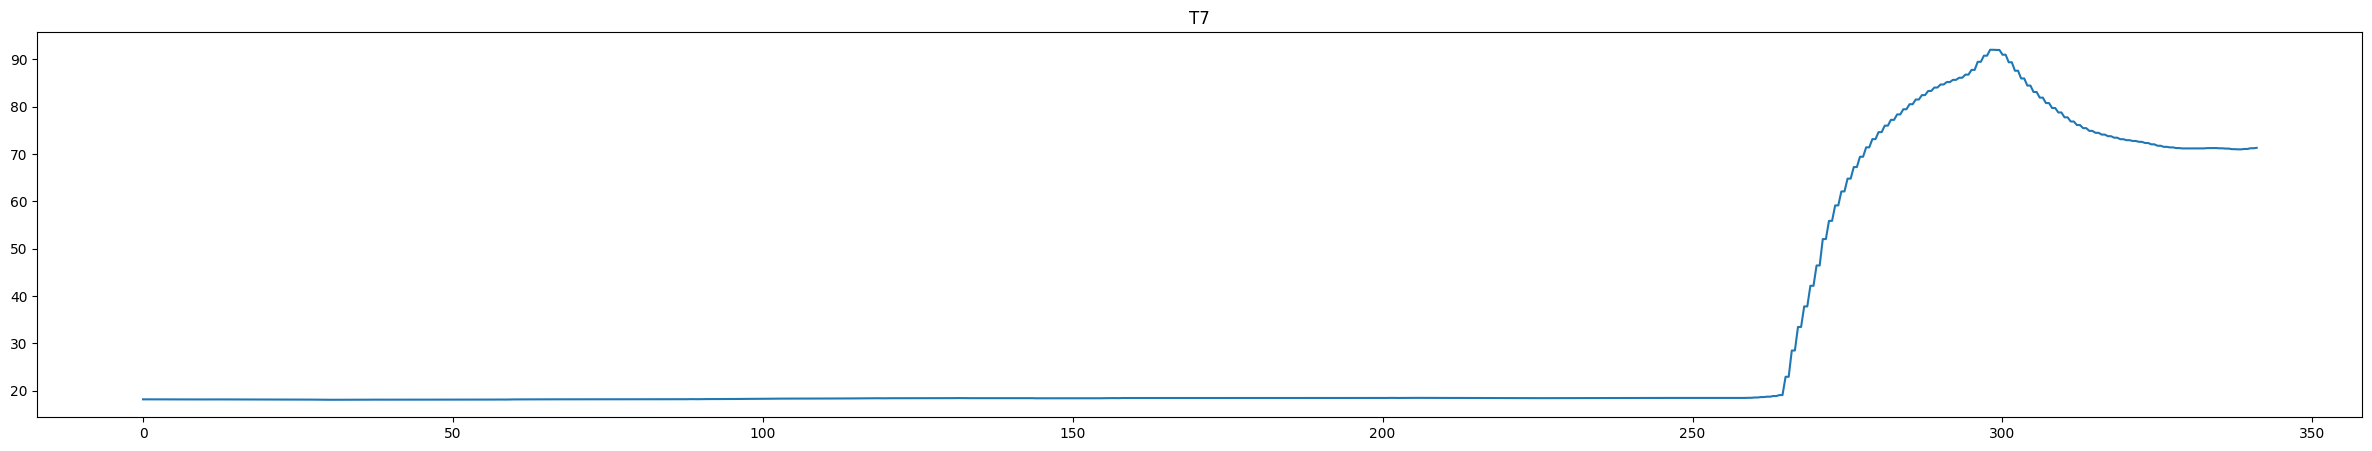

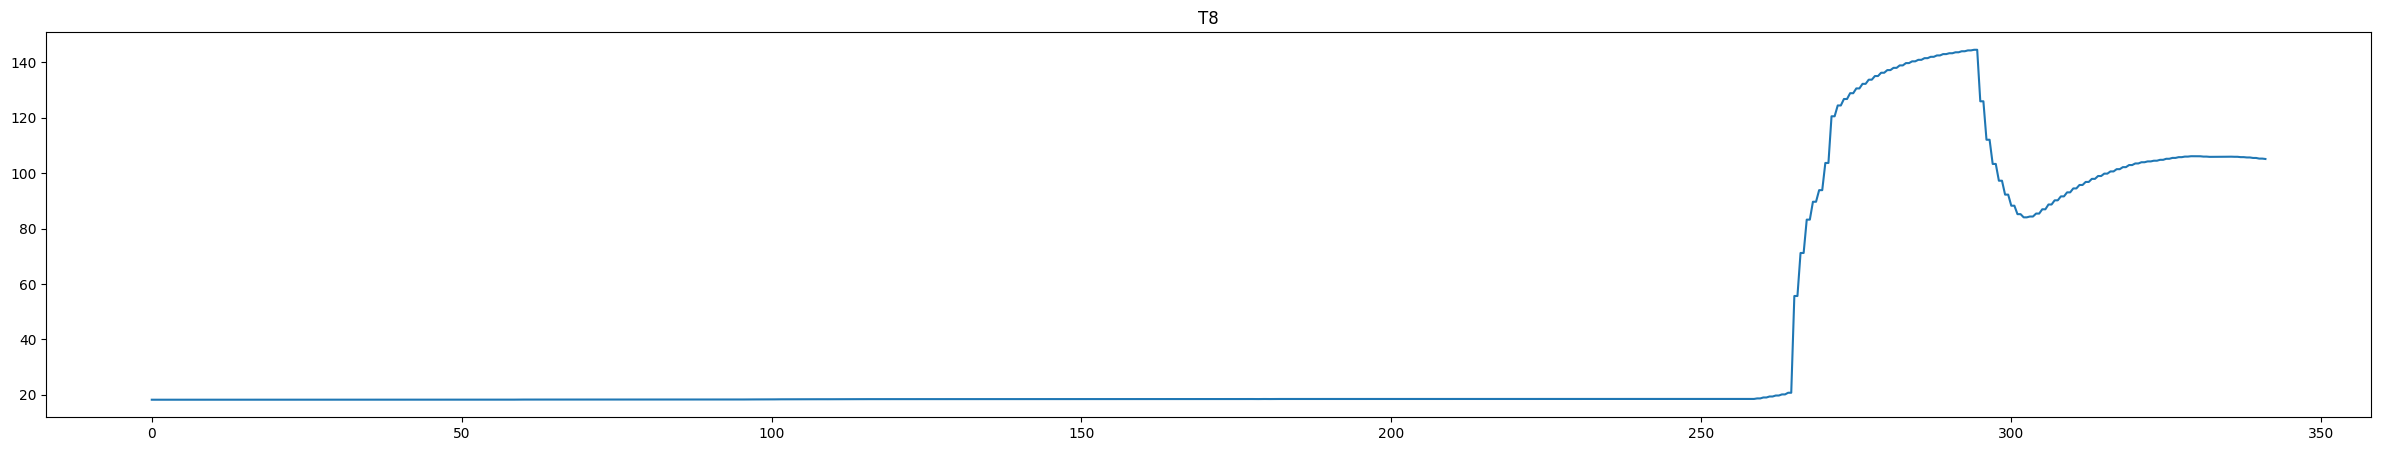

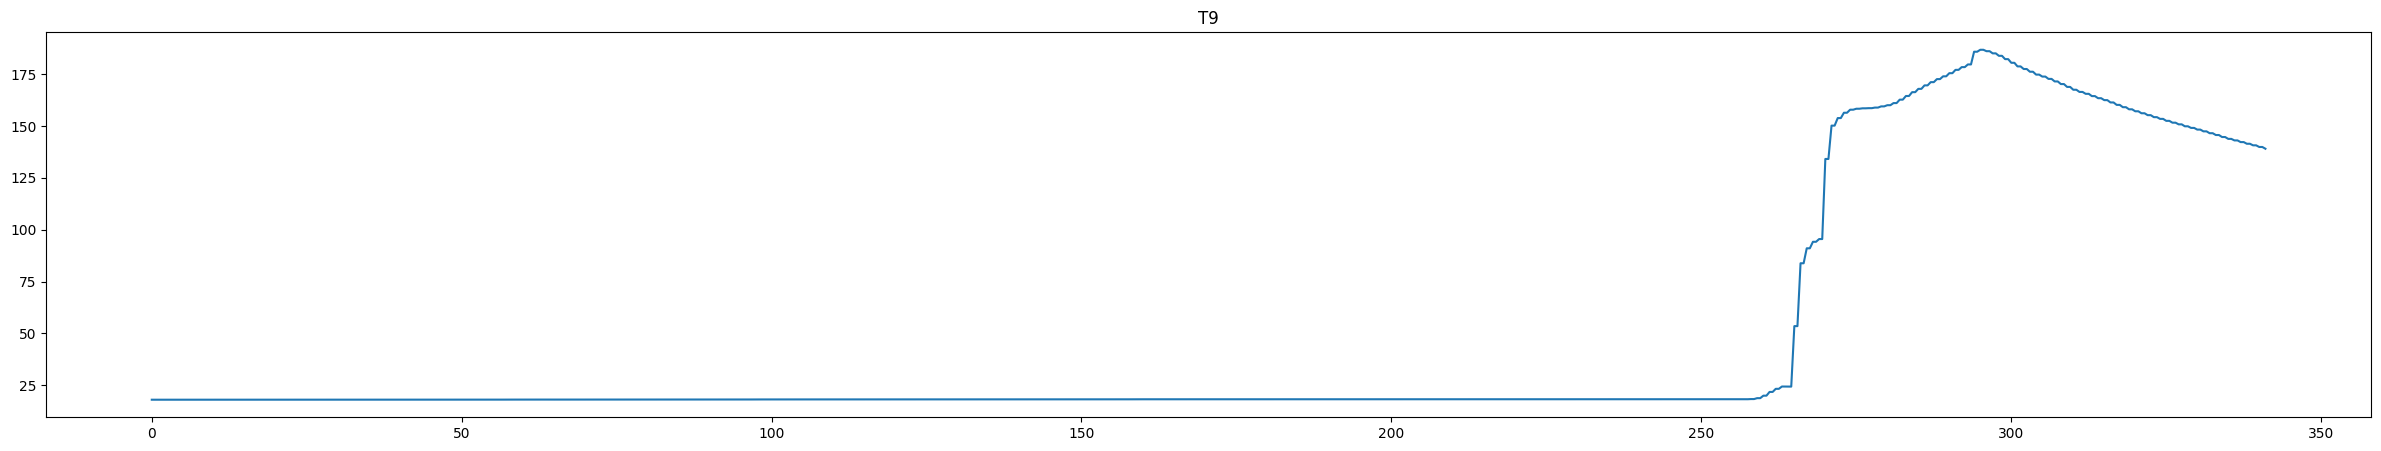

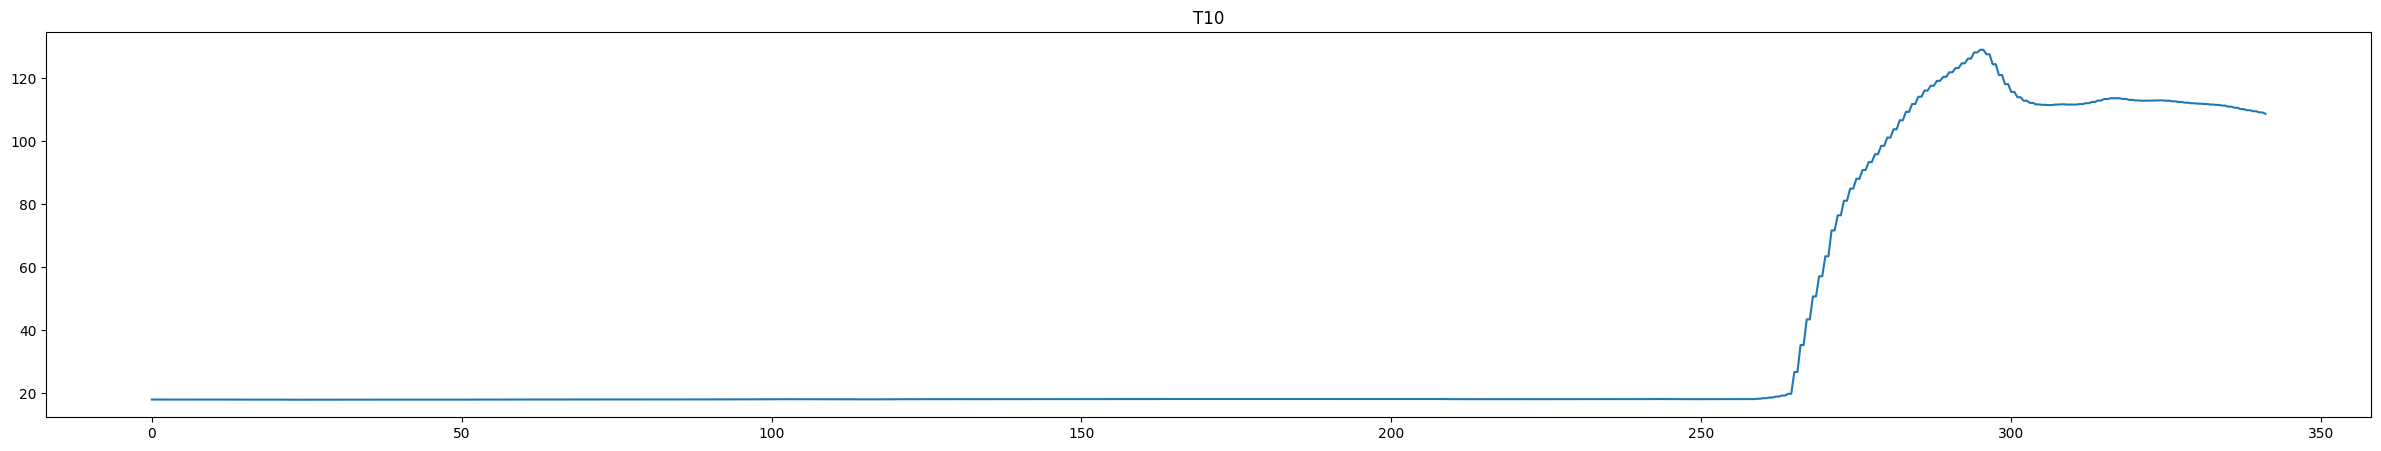

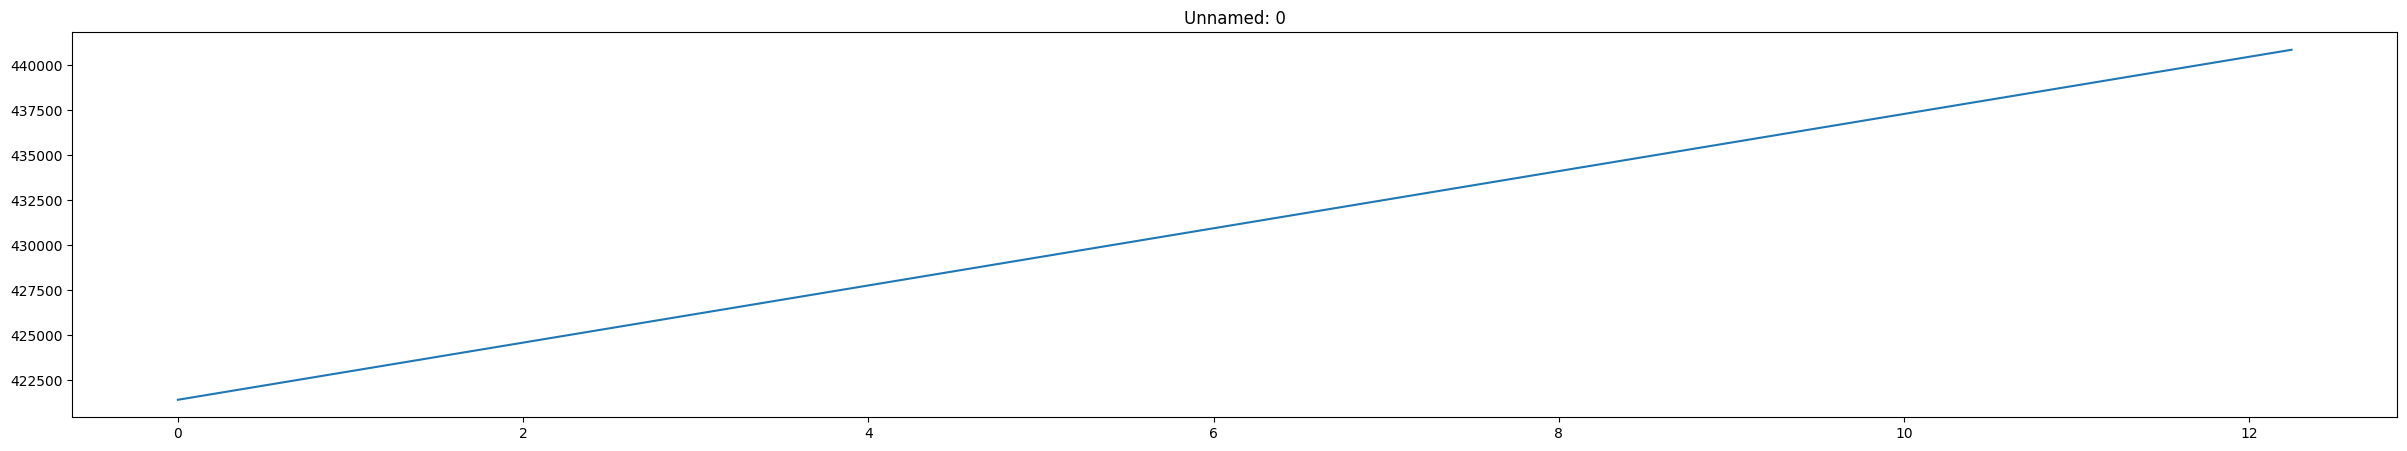

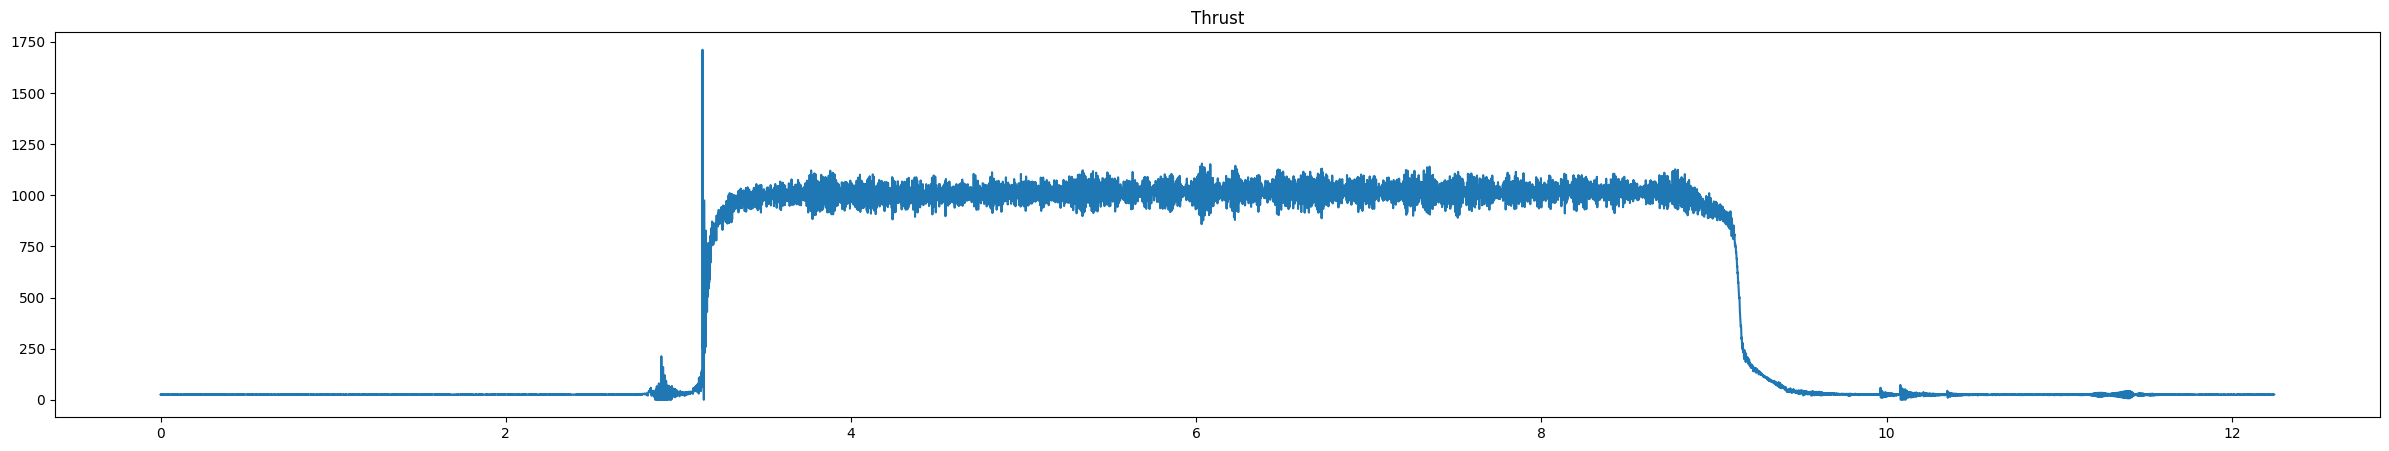

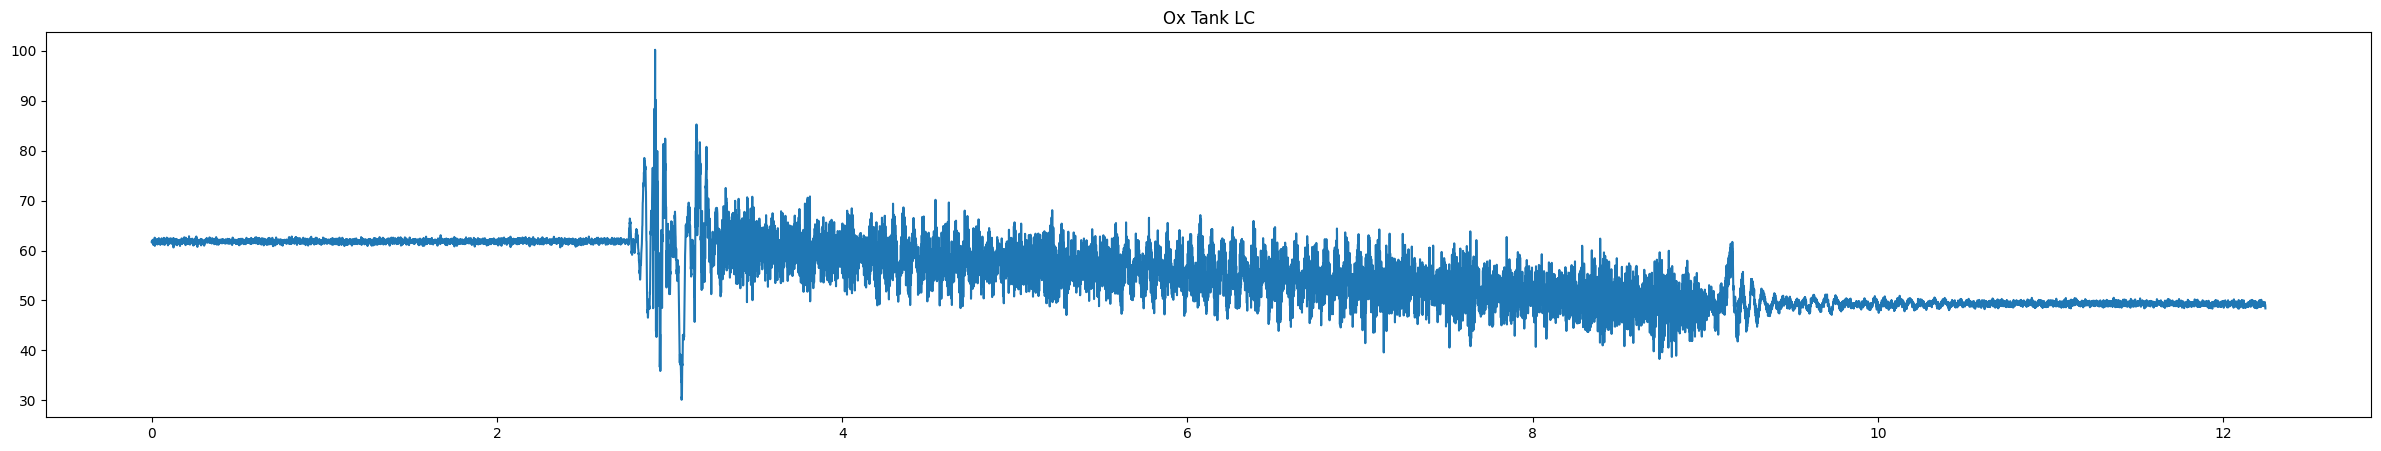

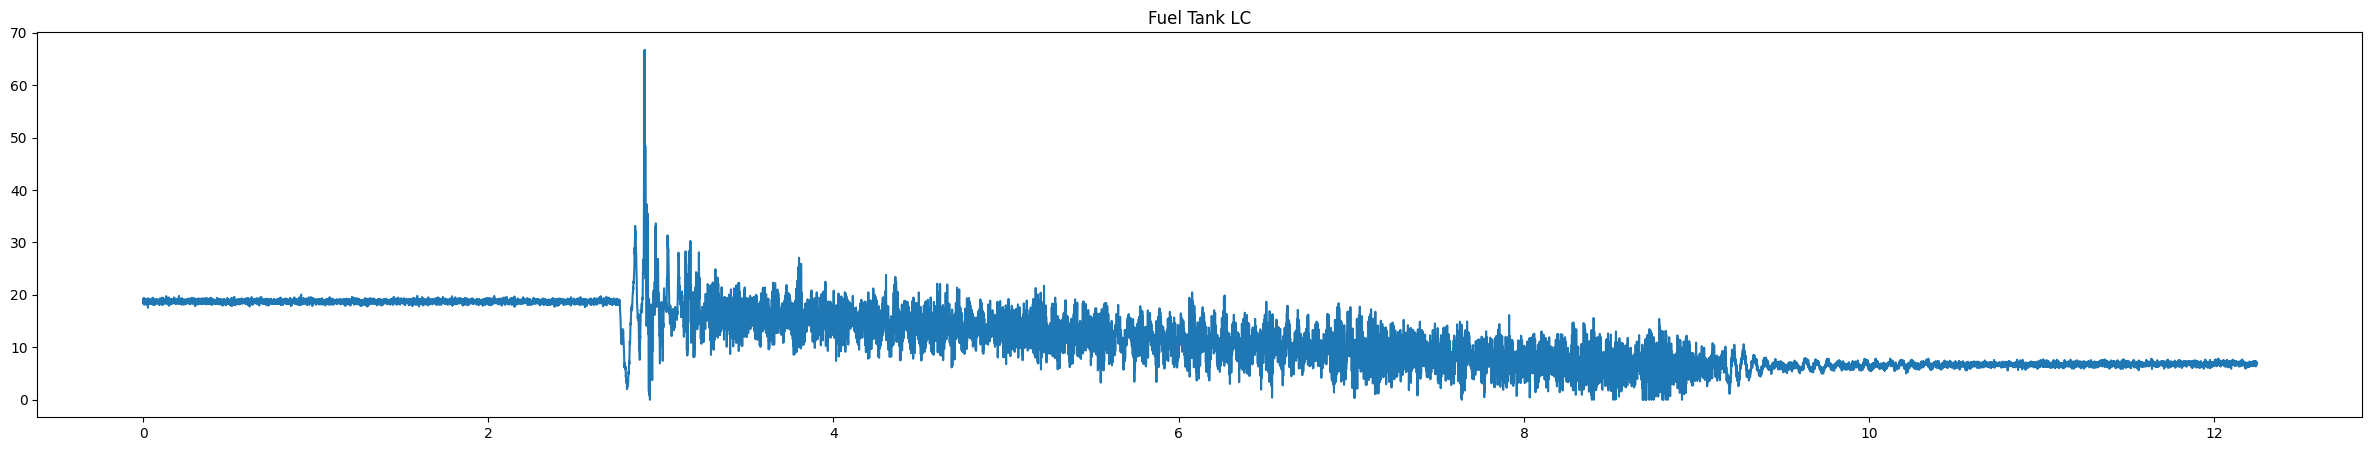

In [35]:
image_index = 0

os.makedirs(f'./clean_data/{static_data}/{burn}/images', exist_ok=True)

for df in [PT_df, TC_df, LC_df]:
    time_col = df['Time (s)']
    data_df = df.drop(columns=['# Time', 'Time (s)'])
    for col in data_df:
        if "cDAQ" not in col:
            plt.plot(time_col, data_df[col])
            plt.title(col)
            plt.savefig(f'./clean_data/{static_data}/{burn}/images/'+ str(image_index) + ' ' + col+'.png') # save images to folder
            image_index += 1
            plt.show()

# Calc Stats

In [36]:
# TC indexes 
if math.isnan(start_steady_state_TC):  # Check if NaN
    start_steady_state_TC = TC_df.index[0]  # Use the first index
else:
    # Find the index of the closest value in "Time (s)"
    closest_index = (TC_df['Time (s)'] - start_steady_state_TC).abs().idxmin()
    start_steady_state_TC = closest_index

if math.isnan(end_steady_state_TC):  # Check if NaN
    end_steady_state_TC = TC_df.index[-1]  # Use the last index
else:
    # Find the index of the closest value in "Time (s)"
    closest_index = (TC_df['Time (s)'] - end_steady_state_TC).abs().idxmin()
    end_steady_state_TC = closest_index

# PT indexes 
if math.isnan(start_steady_state_PT):  # Check if NaN
    start_steady_state_PT = PT_df.index[0]  # Use the first index
else:
    # Find the index of the closest value in "Time (s)"
    closest_index = (PT_df['Time (s)'] - start_steady_state_PT).abs().idxmin()
    start_steady_state_PT = closest_index

if math.isnan(end_steady_state_PT):  # Check if NaN
    end_steady_state_PT = PT_df.index[-1]  # Use the last index
else:
    # Find the index of the closest value in "Time (s)"
    closest_index = (PT_df['Time (s)'] - end_steady_state_PT).abs().idxmin()
    end_steady_state_PT = closest_index

# LC indexes 
if math.isnan(start_steady_state_LC):  # Check if NaN
    start_steady_state_LC = LC_df.index[0]  # Use the first index
else:
    # Find the index of the closest value in "Time (s)"
    closest_index = (LC_df['Time (s)'] - start_steady_state_LC).abs().idxmin()
    start_steady_state_LC = closest_index

if math.isnan(end_steady_state_LC):  # Check if NaN
    end_steady_state_LC = LC_df.index[-1]  # Use the last index
else:
    # Find the index of the closest value in "Time (s)"
    closest_index = (LC_df['Time (s)'] - end_steady_state_LC).abs().idxmin()
    end_steady_state_LC = closest_index

# Debugging output
print(f"TC: {start_steady_state_TC} to {end_steady_state_TC}")
print(f"PT: {start_steady_state_PT} to {end_steady_state_PT}")
print(f"LC: {start_steady_state_LC} to {end_steady_state_LC}")


TC: 0 to 682
PT: 1000 to 5000
LC: 1590 to 7948


In [37]:

steady_thrust = LC_df['Thrust'][start_steady_state_LC:end_steady_state_LC] 

chamber_pressure =( (PT_df['Chamber Right '] + PT_df['Chamber Left ']) / 2)

Ox_tank = PT_df['Top Ox Tank '][start_steady_state_PT:end_steady_state_PT] 
Fuel_tank = PT_df['Top Fuel Tank '][start_steady_state_PT:end_steady_state_PT] 

print('Average thrust:', round(np.average(steady_thrust)), 'lbf\n')

print('Average chamber pressure (top):', round(np.average(PT_df['Chamber Top'][start_steady_state_PT:end_steady_state_PT] )), 'psi')
print('Average chamber pressure (left):', round(np.average(PT_df['Chamber Left '][start_steady_state_PT:end_steady_state_PT] )), 'psi')
print('Average chamber pressure (right):', round(np.average(PT_df['Chamber Right '][start_steady_state_PT:end_steady_state_PT] )), 'psi')
print('Average chamber pressure (bottom):', round(np.average(PT_df['Chamber Bottom '][start_steady_state_PT:end_steady_state_PT] )), 'psi\n')

print('Average chamber pressure (right/left):', round(np.average(chamber_pressure[start_steady_state_PT:end_steady_state_PT] )), 'psi\n')


print('Average Ox tank pressure:', round(np.average(Ox_tank)), 'psi')
print('Average fuel tank pressure:', round(np.average(Fuel_tank)), 'psi\n')

#pressure drop through a regen channel
regen_drop = np.subtract(PT_df['Regen In 1'], PT_df['Regen Out '])
regen_drop = regen_drop[start_steady_state_PT:end_steady_state_PT]
regen_drop = np.average(regen_drop)
print("Pressure Drop Through Regen Channel:", round(regen_drop), 'psi\n')

#pressure drop through mini stand fuel side
stand_drop = np.subtract(PT_df['Top Fuel Tank '], PT_df['Regen In 1'])
stand_drop = stand_drop[start_steady_state_PT:end_steady_state_PT]
stand_drop = np.average(stand_drop)
print("Pressure drop thorugh ministand fuel side:", round(stand_drop), 'psi')

#pressure drop through mini stand lox side
stand_drop = np.subtract(PT_df['Top Ox Tank '], PT_df['LOX Engine Inlet '])
stand_drop = stand_drop[start_steady_state_PT:end_steady_state_PT]
stand_drop = np.average(stand_drop)
print("Pressure drop thorugh ministand lox side:", round(stand_drop), 'psi\n')

#pressure drop through annulus
ann_drop = np.subtract(PT_df['Regen Out '], chamber_pressure)
ann_drop = ann_drop[start_steady_state_PT:end_steady_state_PT]
ann_drop = np.average(ann_drop)
print("Pressure drop through annulus:", round(ann_drop), 'psi')

#presssure drop through pintle
pintle_drop = np.subtract(PT_df['LOX Engine Inlet '], chamber_pressure)
pintle_drop = pintle_drop[start_steady_state_PT:end_steady_state_PT]
pintle_drop = np.average(pintle_drop)
print("Pressure drop through pintle:", round(pintle_drop), 'psi\n')

#inlet pressure oxygen
print("Average LOX inlet:", round(np.average(PT_df['LOX Engine Inlet '][start_steady_state_PT:end_steady_state_PT])), 'psi')

#inlet pressure fuel
print("Average Fuel inlet (regen 1):", round(np.average(PT_df['Regen In 1'][start_steady_state_PT:end_steady_state_PT])), 'psi')
print("Average Fuel inlet (regen 2):", round(np.average(PT_df['Regen In 2'][start_steady_state_PT:end_steady_state_PT])), 'psi\n')


#tank decay rate during "steady state"
Ox_0 = PT_df['Top Ox Tank '][start_steady_state_PT]
Ox_f = PT_df['Top Ox Tank '][end_steady_state_PT]
dP_Ox = Ox_f-Ox_0

Fuel_0 = PT_df['Top Fuel Tank '][start_steady_state_PT]
Fuel_f = PT_df['Top Fuel Tank '][end_steady_state_PT]
dP_Fuel = Fuel_f-Fuel_0

t_0 = PT_df['Time (s)'][start_steady_state_PT]
t_f = PT_df['Time (s)'][end_steady_state_PT]
dt = t_f-t_0

decay_Ox = dP_Ox/dt
decay_Fuel = dP_Fuel/dt

print("Ox tank pressure decay:", round(decay_Ox,3), 'psi/s')
print("Fuel tank pressure decay:", round(decay_Fuel,3), 'psi/s\n')

#total impulse of burn
impulse = np.trapezoid(LC_df['Thrust'], LC_df['Time (s)'])
print("Impulse", round(impulse), 'lbf*s')


Average thrust: 472 lbf

Average chamber pressure (top): 42 psi
Average chamber pressure (left): 42 psi
Average chamber pressure (right): 41 psi
Average chamber pressure (bottom): 7 psi

Average chamber pressure (right/left): 41 psi

Average Ox tank pressure: 478 psi
Average fuel tank pressure: 603 psi

Pressure Drop Through Regen Channel: 18 psi

Pressure drop thorugh ministand fuel side: 568 psi
Pressure drop thorugh ministand lox side: 429 psi

Pressure drop through annulus: -24 psi
Pressure drop through pintle: 7 psi

Average LOX inlet: 49 psi
Average Fuel inlet (regen 1): 35 psi
Average Fuel inlet (regen 2): 35 psi

Ox tank pressure decay: -5.786 psi/s
Fuel tank pressure decay: -4.998 psi/s

Impulse 6206 lbf*s


### Performance 

In [38]:
## TODO make better

end_index = len(LC_df)
delta_weight_lox = np.average(LC_df['Ox Tank LC'][1:4000])-np.average(LC_df['Ox Tank LC'][end_index-4000:end_index])
delta_weight_fuel = np.average(LC_df['Fuel Tank LC'][1:4000])-np.average(LC_df['Fuel Tank LC'][end_index-4000:end_index])
isp = impulse/(delta_weight_fuel+delta_weight_lox)

firing_time = PT_df['Time (s)'].iloc[len(PT_df['Time (s)'])-5000]-PT_df['Time (s)'].iloc[5000]
m_dot_ox = delta_weight_lox/firing_time
m_dot_fuel = delta_weight_fuel/firing_time
kg_s_ox = m_dot_ox/2.205
kg_s_fuel = m_dot_fuel/2.205

A_throat = np.pi*(1.6/2)**2
C_star = (np.average(PT_df['Chamber Bottom '])*A_throat)/(np.average(m_dot_fuel+m_dot_ox)/32.174)

print('ISP:', round(isp,2), 'seconds')
print('C*:', round(C_star,2), 'ft/s')
print('C* efficiency', round(C_star*100/5610,2), '%')

print('mdot Ox:', round(kg_s_ox,3), 'kg/s')
print('mdot Fuel:', round(kg_s_fuel,3), 'kg/s')
print('mdot:', round(kg_s_fuel+kg_s_ox,3), 'kg/s')
print('O:F', round(m_dot_ox/m_dot_fuel,3))

print('expected mdot Ox: 0.8736')
print('expected mdot Fuel: 1.0483')
print('expected mdot:', 0.8736+1.0483)
print('expected O:F', round((1.0483/.8736),3))

ISP: 253.33 seconds
C*: 1911.44 ft/s
C* efficiency 34.07 %
mdot Ox: 0.976 kg/s
mdot Fuel: 0.94 kg/s
mdot: 1.916 kg/s
O:F 1.038
expected mdot Ox: 0.8736
expected mdot Fuel: 1.0483
expected mdot: 1.9219
expected O:F 1.2


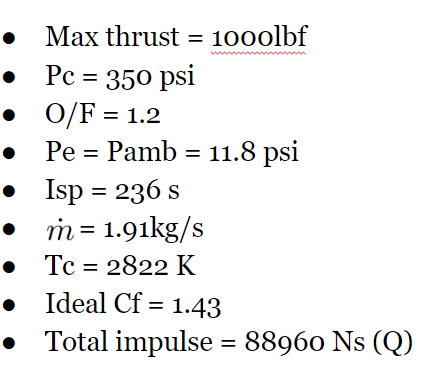

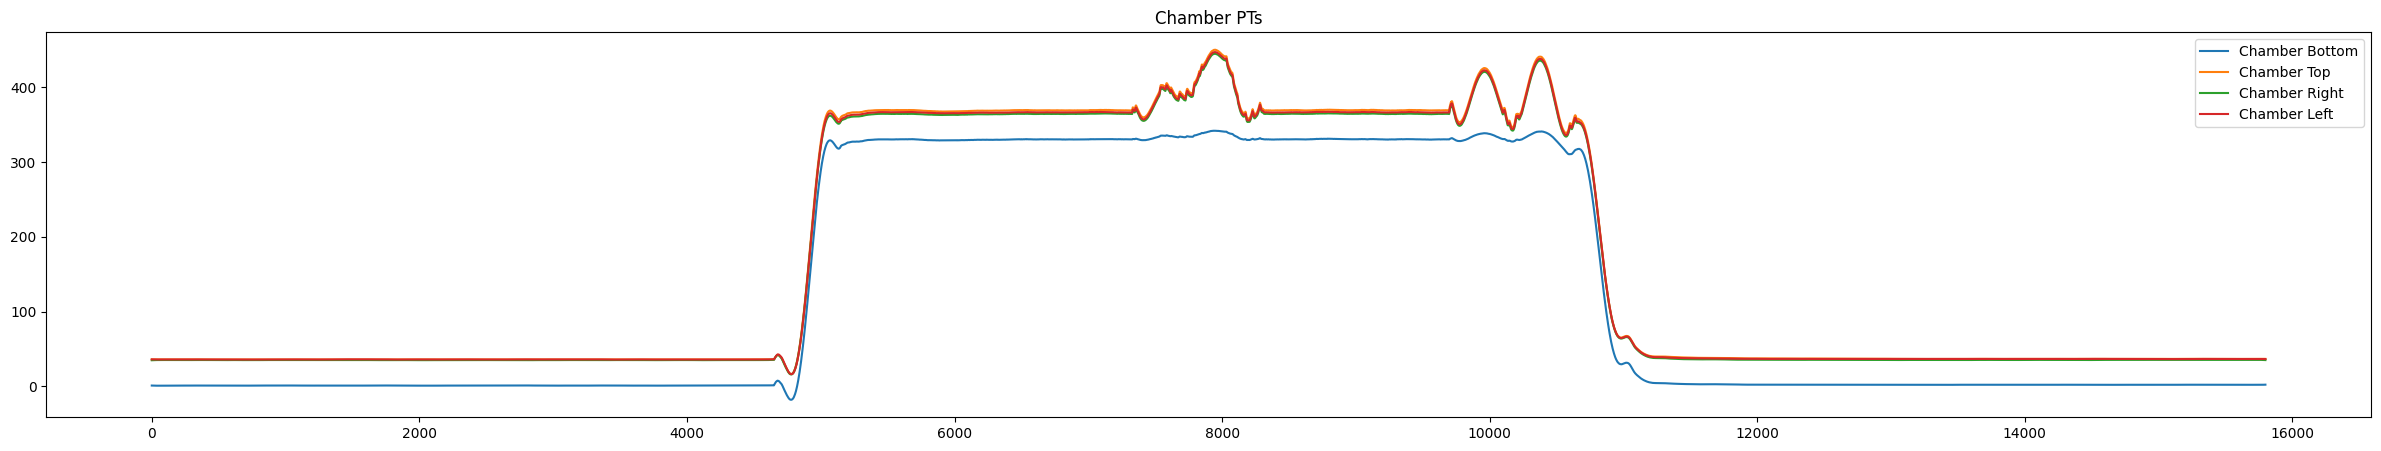

In [39]:
plt.plot(signal.savgol_filter(PT_df['Chamber Bottom '], 501, 5))
plt.plot(signal.savgol_filter(PT_df['Chamber Top'], 501, 5))
plt.plot(signal.savgol_filter(PT_df['Chamber Right '], 501, 5))
plt.plot(signal.savgol_filter(PT_df['Chamber Left '], 501, 5))
plt.legend(['Chamber Bottom','Chamber Top', 'Chamber Right ', 'Chamber Left '])
plt.title('Chamber PTs')
plt.savefig(f'./clean_data/{static_data}/{burn}/images/'+ str(image_index) + ' ' + 'AllChamber.png') 
image_index += 1
plt.show()


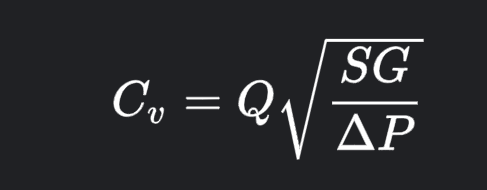

In [40]:
# delta_p_ox = np.average(PT_df['Top Ox Tank '][5000:len(PT_df['Time (s)'])-5000]-PT_df['Chamber Right '][5000:len(PT_df['Time (s)'])-5000])
# delta_p_fuel = np.average(PT_df['Top Fuel Tank '][5000:len(PT_df['Time (s)'])-5000]-PT_df['Chamber Right '][5000:len(PT_df['Time (s)'])-5000])

# Q_ox = (1/1141 )*(kg_s_ox)
# Q_fuel = (1/789)*(kg_s_fuel)

# SG_ox = 1.141  #where SG =1 for water
# SG_fuel = 0.789

# Q_ox_gpm = Q_ox*264.2
# Q_fuel_gpm = Q_fuel*264.2

# Cv_ox = Q_ox_gpm*np.sqrt(SG_ox/delta_p_ox)
# Cv_fuel = Q_fuel_gpm*np.sqrt(SG_ox/delta_p_fuel)

# print('Cv Ox:', round(Cv_ox, 5))
# print('Cv Fuel:', round(Cv_fuel, 5))

max amplitude @ 0.2499937393374194 Hz


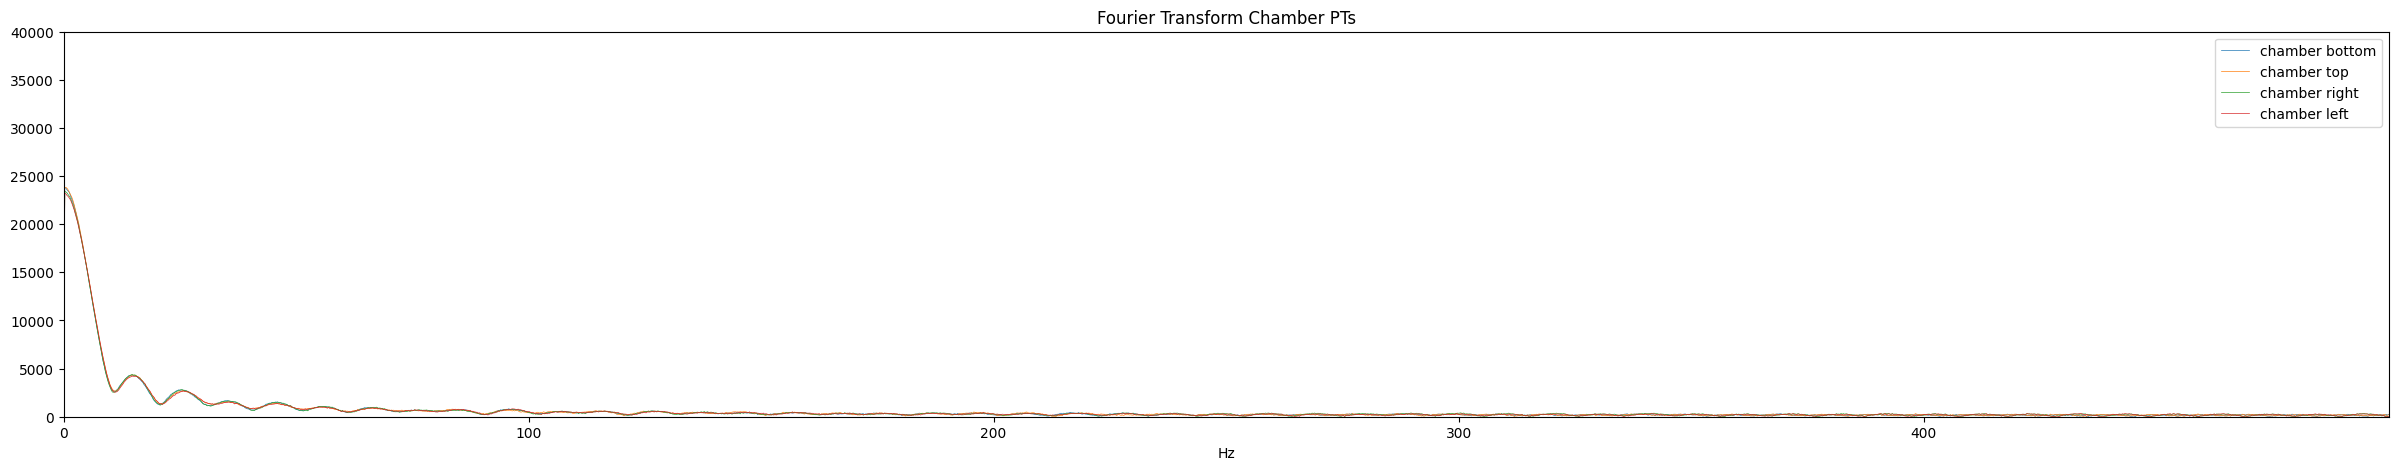

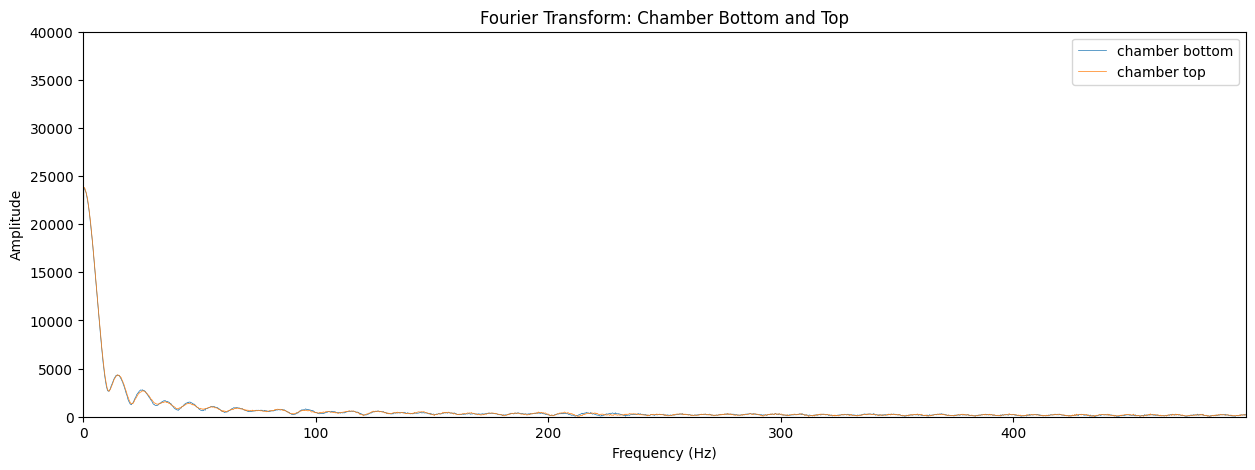

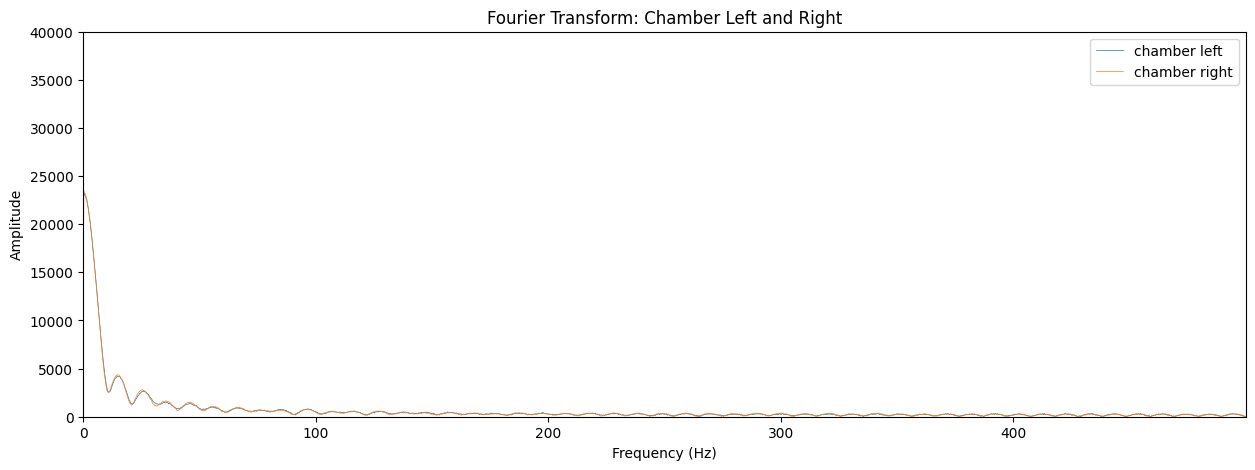

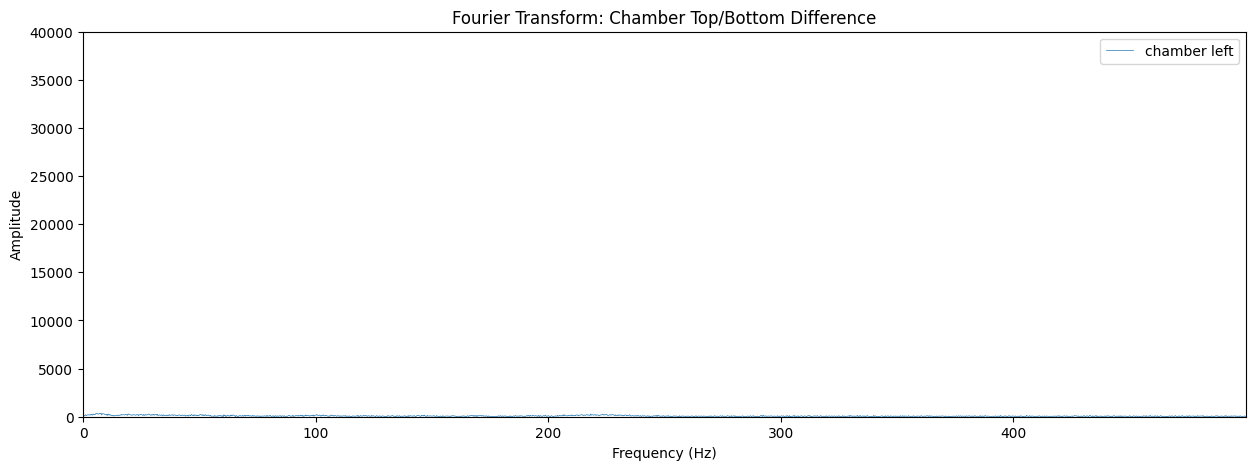

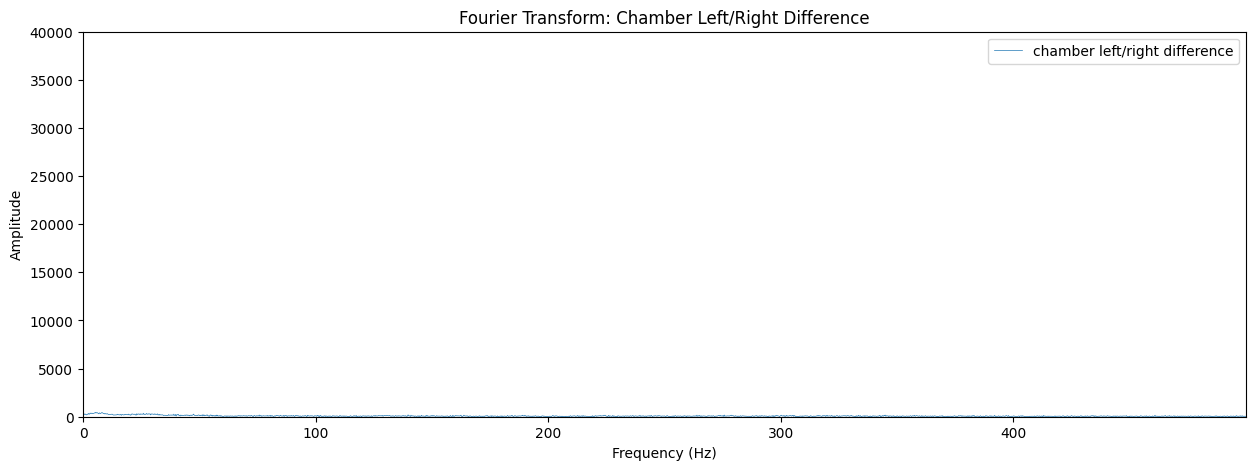

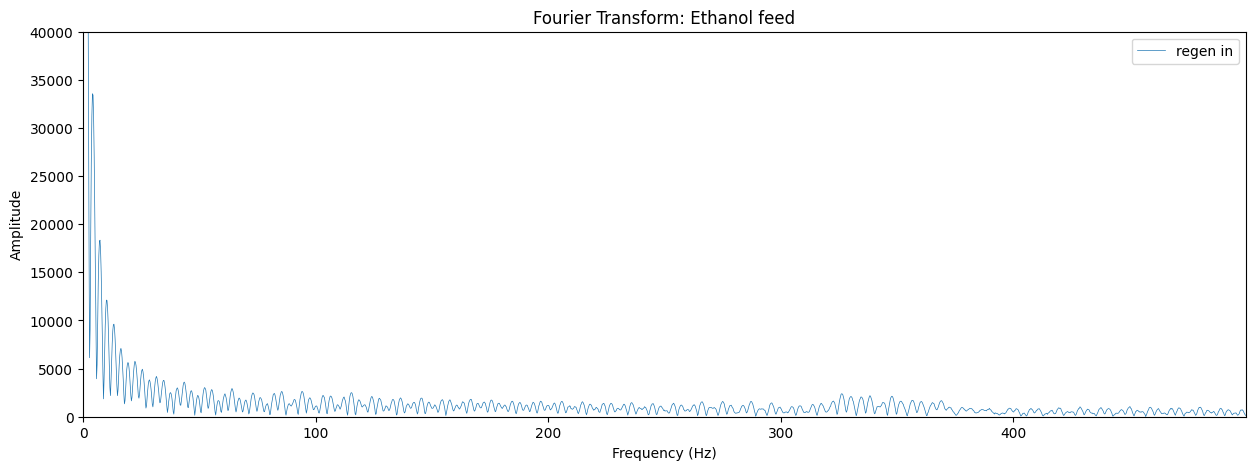

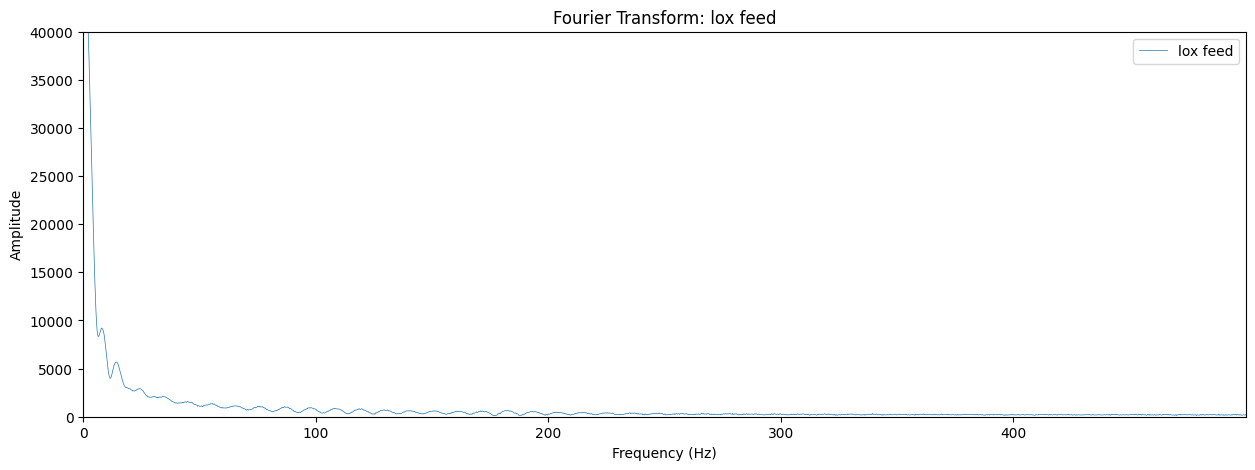

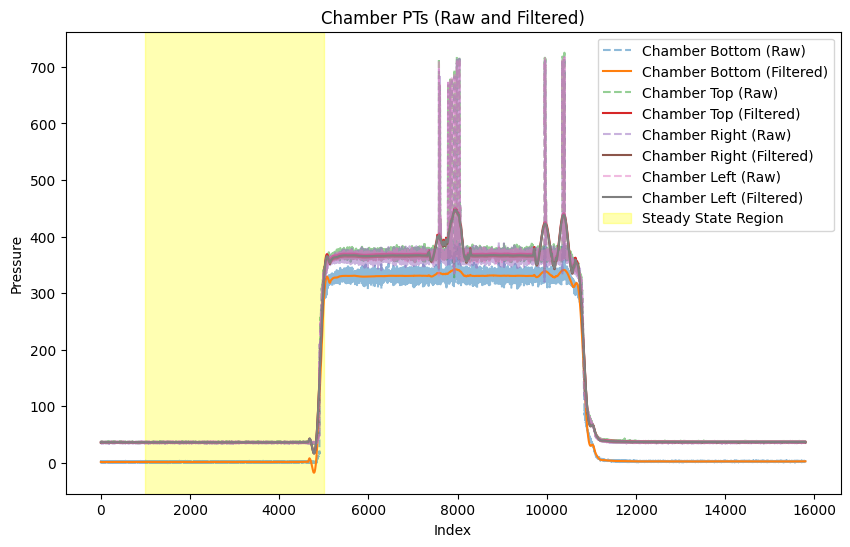

In [41]:
#frequncy analysis of the chamber pressure

chamber_b = np.array(PT_df['Chamber Bottom '])
chamber_b = np.subtract(chamber_b, np.average(chamber_b))
chamber_b = chamber_b[start_steady_state_PT:end_steady_state_PT]
chamber_b = np.subtract(chamber_b, np.average(chamber_b))

chamber_t = np.array(PT_df['Chamber Top'])
chamber_t = np.subtract(chamber_t, np.average(chamber_t))
chamber_t = chamber_t[start_steady_state_PT:end_steady_state_PT]
chamber_t = np.subtract(chamber_t, np.average(chamber_t))

chamber_r = np.array(PT_df['Chamber Right '])
chamber_r = np.subtract(chamber_r, np.average(chamber_r))
chamber_r = chamber_r[start_steady_state_PT:end_steady_state_PT]
chamber_r = np.subtract(chamber_r, np.average(chamber_r))

chamber_l = np.array(PT_df['Chamber Left '])
chamber_l = np.subtract(chamber_l, np.average(chamber_l))
chamber_l = chamber_l[start_steady_state_PT:end_steady_state_PT]
chamber_l = np.subtract(chamber_l, np.average(chamber_l))

regen_in = np.array(PT_df['Regen In 1'])
regen_in = np.subtract(regen_in, np.average(regen_in))
regen_in = regen_in[start_steady_state_PT:end_steady_state_PT]
regen_in = np.subtract(regen_in, np.average(regen_in))

regen_out = np.array(PT_df['Regen Out '])
regen_out = np.subtract(regen_out, np.average(regen_out))
regen_out = regen_out[start_steady_state_PT:end_steady_state_PT]
regen_out = np.subtract(regen_out, np.average(regen_out))

tank_fuel = np.array(PT_df['Top Fuel Tank '])
tank_fuel = np.subtract(tank_fuel, np.average(tank_fuel))
tank_fuel = tank_fuel[start_steady_state_PT:end_steady_state_PT]
tank_fuel = np.subtract(tank_fuel, np.average(tank_fuel))

tank_ox = np.array(PT_df['Top Ox Tank '])
tank_ox = np.subtract(tank_ox, np.average(tank_ox))
tank_ox = tank_ox[start_steady_state_PT:end_steady_state_PT]
tank_ox = np.subtract(tank_ox, np.average(tank_ox))

ox_inlet = np.array(PT_df['LOX Engine Inlet '])
ox_inlet = np.subtract(ox_inlet, np.average(ox_inlet))
ox_inlet = ox_inlet[start_steady_state_PT:end_steady_state_PT]
ox_inlet = np.subtract(ox_inlet, np.average(ox_inlet))
#find sample rate
# Calculate the time differences between consecutive rows
time_diffs = PT_df['Time (s)'].diff()

# Get the mean sample rate in Hz (samples per second)
sr = 1 / time_diffs.mean()
#fourier
chamber_b_f = rfft(chamber_b)
chamber_t_f = rfft(chamber_t)
chamber_r_f = rfft(chamber_r)
chamber_l_f = rfft(chamber_l)

regen_in_f = rfft(regen_in)
regen_out_f = rfft(regen_out)

tank_fuel_f = rfft(tank_fuel)
tank_ox_f = rfft(tank_ox)

xf = rfftfreq(len(chamber_b), 1/sr)

# Plot the result (the spectrum |Xk|)
plt.rcParams["figure.figsize"] = (30,5)

plt.plot(xf, np.abs(chamber_b_f), linewidth = .5)
plt.plot(xf, np.abs(chamber_t_f), linewidth = .5)
plt.plot(xf, np.abs(chamber_r_f), linewidth = .5)
plt.plot(xf, np.abs(chamber_l_f), linewidth = .5)

# plt.plot(xf, np.abs(regen_in_f), linewidth = .5)
# plt.plot(xf, np.abs(regen_out_f), linewidth = .5)

# plt.plot(xf, np.abs(tank_fuel_f), linewidth = .5)
# plt.plot(xf, np.abs(tank_ox_f), linewidth = .5)

max_index = np.argmax(chamber_b_f)
print('max amplitude @', xf[max_index], 'Hz')

plt.xlim((0,sr/2))
plt.ylim((0,40000))
plt.legend(['chamber bottom', 'chamber top', 'chamber right', 'chamber left','regen_in','regen_out', 'tank fuel', 'tank ox' ])
plt.xlabel('Hz')
plt.title('Fourier Transform Chamber PTs')
plt.savefig(f'./clean_data/{static_data}/{burn}/images/'+ str(image_index) + ' ' + 'fft.png')
image_index += 1
plt.show()

# Plot for chamber_b and chamber_t
plt.figure(figsize=(15, 5))
plt.plot(xf, np.abs(chamber_b_f), linewidth=0.5, label='chamber bottom')
plt.plot(xf, np.abs(chamber_t_f), linewidth=0.5, label='chamber top')
plt.xlim((0, sr/2))
plt.ylim((0, 40000))
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Fourier Transform: Chamber Bottom and Top')
plt.savefig(f'./clean_data/{static_data}/{burn}/images/' + str(image_index) + ' chamber_b_t_fft.png')
image_index += 1
plt.show()

# Plot for chamber_l and chamber_r
plt.figure(figsize=(15, 5))
plt.plot(xf, np.abs(chamber_l_f), linewidth=0.5, label='chamber left')
plt.plot(xf, np.abs(chamber_r_f), linewidth=0.5, label='chamber right')
plt.xlim((0, sr/2))
plt.ylim((0, 40000))
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Fourier Transform: Chamber Left and Right')
plt.savefig(f'./clean_data/{static_data}/{burn}/images/' + str(image_index) + ' chamber_l_r_fft.png')
image_index += 1
plt.show()

# Plot for chamber_t - chamber_b
plt.figure(figsize=(15, 5))
plt.plot(xf, np.abs( rfft(chamber_t-chamber_b)), linewidth=0.5, label='chamber left')
plt.xlim((0, sr/2))
plt.ylim((0, 40000))
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Fourier Transform: Chamber Top/Bottom Difference')
plt.savefig(f'./clean_data/{static_data}/{burn}/images/' + str(image_index) + ' chamber_t_b_difference_fft.png')
image_index += 1
plt.show()

# Plot for chamber_l - chamber_r
plt.figure(figsize=(15, 5))
plt.plot(xf, np.abs( rfft(chamber_l-chamber_r)), linewidth=0.5, label='chamber left/right difference')
plt.xlim((0, sr/2))
plt.ylim((0, 40000))
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Fourier Transform: Chamber Left/Right Difference')
plt.savefig(f'./clean_data/{static_data}/{burn}/images/' + str(image_index) + ' chamber_l_r_difference_fft.png')
image_index += 1
plt.show()

# Plot for ethhanol
plt.figure(figsize=(15, 5))
plt.plot(xf, np.abs( rfft(regen_in)), linewidth=0.5, label='regen in')
plt.xlim((0, sr/2))
plt.ylim((0, 40000))
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Fourier Transform: Ethanol feed')
plt.savefig(f'./clean_data/{static_data}/{burn}/images/' + str(image_index) + ' chamber_l_r_difference_fft.png')
image_index += 1
plt.show()

# Plot for lox
plt.figure(figsize=(15, 5))
plt.plot(xf, np.abs( rfft(ox_inlet)), linewidth=0.5, label='lox feed')
plt.xlim((0, sr/2))
plt.ylim((0, 40000))
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Fourier Transform: lox feed')
plt.savefig(f'./clean_data/{static_data}/{burn}/images/' + str(image_index) + ' chamber_l_r_difference_fft.png')
image_index += 1
plt.show()

plt.figure(figsize=(10, 6))

# Plot raw and filtered data for each column
plt.plot(PT_df['Chamber Bottom '], label='Chamber Bottom (Raw)', alpha=0.5, linestyle='--')
plt.plot(signal.savgol_filter(PT_df['Chamber Bottom '], 501, 5), label='Chamber Bottom (Filtered)')

plt.plot(PT_df['Chamber Top'], label='Chamber Top (Raw)', alpha=0.5, linestyle='--')
plt.plot(signal.savgol_filter(PT_df['Chamber Top'], 501, 5), label='Chamber Top (Filtered)')

plt.plot(PT_df['Chamber Right '], label='Chamber Right (Raw)', alpha=0.5, linestyle='--')
plt.plot(signal.savgol_filter(PT_df['Chamber Right '], 501, 5), label='Chamber Right (Filtered)')

plt.plot(PT_df['Chamber Left '], label='Chamber Left (Raw)', alpha=0.5, linestyle='--')
plt.plot(signal.savgol_filter(PT_df['Chamber Left '], 501, 5), label='Chamber Left (Filtered)')

# Highlight the steady state region
plt.axvspan(start_steady_state_PT, end_steady_state_PT, color='yellow', alpha=0.3, label='Steady State Region')

# Add title, legend, and labels
plt.title('Chamber PTs (Raw and Filtered)')
plt.xlabel('Index')
plt.ylabel('Pressure')
plt.legend()

# Save the plot
plt.savefig(f'./clean_data/{static_data}/{burn}/images/' + str(image_index) + ' ' + 'AllChamber_Highlighted.png') 
image_index += 1

# Show the plot
plt.show()

### Create PDF of all data

In [42]:
# # convert all files ending in .jpg inside a directory
# dirname = "C:/Users/alexr/OneDrive/Documents/NI_Logging/images/"
# imgs = []

# os.chdir(dirname)
# sorted(filter(os.path.isfile, os.listdir('.')), key=os.path.getmtime)

# for fname in os.listdir(dirname):
# 	if not fname.endswith(".png"):
# 		continue
# 	path = os.path.join(dirname, fname)
# 	if os.path.isdir(path):
# 		continue
# 	imgs.append(path)
# with open("C:/Users/alexr/OneDrive/Documents/NI_Logging/images/Static.pdf","wb") as f:
# 	f.write(img2pdf.convert(imgs))

### Create Excel File 

In [ ]:
# with pd.ExcelWriter('C:/Users/alexr/OneDrive/Documents/NI_Logging/images/"StaticData.xlsx') as writer:
#     PT_df.to_excel(writer, sheet_name='Pressure')
#     TC_df.to_excel(writer, sheet_name='Temperature')
#     LC_df.to_excel(writer, sheet_name='Force')